#### Install DiadFit and import necessary packages

### Downloading locally
    - You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
    - Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [96]:
#!pip install DiadFit
#!pip install DiadFit --upgrade


### Now import the packages you need
    - When you communicate bugs with Penny, make sure you specify the version here.

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lmfit as l
import DiadFit as pf
import scipy
print("SciPy version:", scipy.__version__)
# This needs to be 0.0.68 or higher!
print("You are using DiadFit version" + " " + pf.__version__)


SciPy version: 1.10.1
You are using DiadFit version 0.0.74


###  Specifying paths
    -   Put your path here, e.g. where in your computer the spectra and metadata are saved

In [98]:
import os
RamanDataFolder = input("What is the name of the Raman Data Folder? Typically in Month/Day/Year e.g., 9-26-2023")
DayFolder=os.getcwd() + '\\RamanData' + '\\' + RamanDataFolder
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
filetype='headless_txt'
# What is your file extension? .txt, .csv, .xlsx?
file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
prefix_str=' '
# Does your instrument have TruPower?
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower)

#### Applying Ne correction factors following Wieser and Devitre preprint

##### Step 1: Identify all files which contain Ne lines

In [99]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path, 
                      file_ext='txt', ID_str='N', 
                      exclude_str=['NoDiad'], sort=False)

Ne_files

['01 Ne_line_1.txt',
 '04 Ne_line_2.txt',
 '07 Ne_line_3.txt',
 '11 Ne_line_4.txt',
 '14 Ne_line_5.txt',
 '16 Ne_line_6.txt',
 '18 Ne_line_7.txt',
 '21 Ne_line_8.txt',
 '23 Ne_line_9.txt',
 '26 Ne_line_10.txt',
 '29 Ne_line_11.txt',
 '32 Ne_line_12.txt',
 '37 Ne_line_13.txt',
 '39 Ne_line_14.txt',
 '42 Ne_line_15.txt']

##### Step 2: Get Ne line positions for your specific laser wavelength
    - At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [100]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
1           818.699523     5000.0                556.27662
9          1117.086987     5000.0                565.66588
16         1310.480205     5000.0                571.92248
19         1398.915133     5000.0                574.82985
23         1447.564622     7000.0                576.44188

##### Step 3: Calculate the ideal distance between the two lines you are selecting
    - This finds the closest line in the table above for each selected line

In [101]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                    line1_shift=line_1, line2_shift=line_2,
                                    cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Entered Pos Line 1  \
0  330.477634  1117.086987  1447.564622                1117   

   Entered Pos Line 2  
0                1447

##### Step 4: Identify approximate peak positions by tweaking parameters for SciPy 'find_peaks'
    - Select one representative file which will be used to tweak peak identification parameters
    - These identification parameters are fed into the Scipy find_peaks function to identify the appromxate position of each Ne line (and its intensity)
    - Default peak identification parameters are stored in the data class 'Neon_id_config' (e.g., height, prominence, width, threshold)

In [102]:
i=15 # Select one file
filename=Ne_files[i] 
print(filename)

IndexError: list index out of range

##### Plot Ne lines to inspect
    - This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
    - This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.72474   4177.333496  1447.663174       41129.0  3453.533496   

   Peak2_prom  
0     40405.2

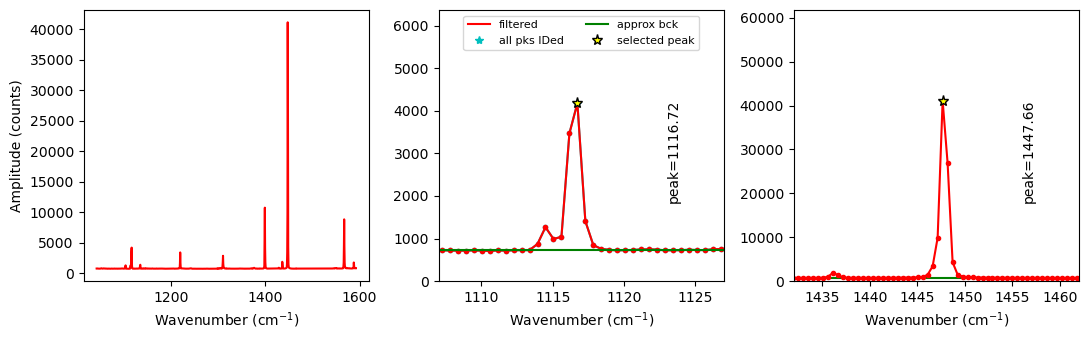

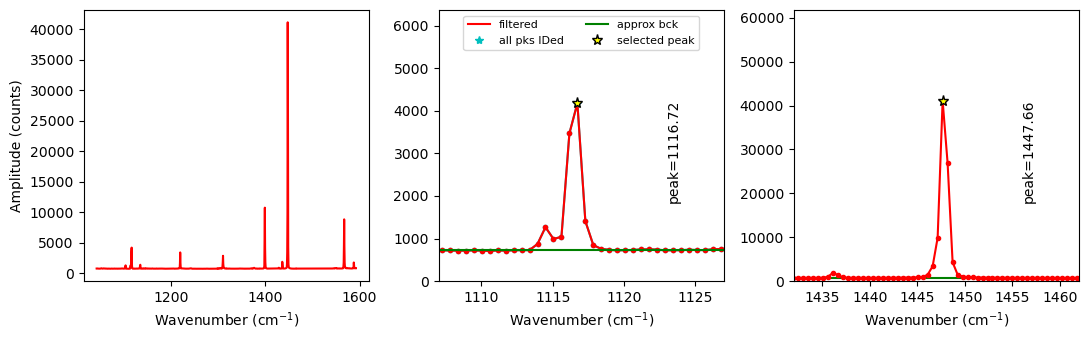

In [ ]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

In [ ]:
Neon_id_config

Neon_id_config(exclude_range_1=None, exclude_range_2=None, height=10, distance=1, prominence=10, width=1, threshold=0.6, peak1_cent=1117, peak2_cent=1447, n_peaks=6)

##### Step 5: Tweak peak fitting parameters for 2 selected lines
    - One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go.
    - Another thing is how many peaks you want for Peak1, ‘peaks_1’, for the 1117 line, you’ll need 2 if you have the clear secondary peak seen above.

In [ ]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [ ]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
                                DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, 
                                LH_offset_mini=[0.5, 3],
                                pk1_sigma=0.6, pk2_sigma=0.3,
                                lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
                                lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
                                x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
                                N_poly_pk2_baseline=2 )

##### Step 6: Use tweaked peak fit parameters to fit one spectra file with the function fit_Ne_lines
    - fit_Ne_lines returns the peak positions and other fit parameters, as well as graphs showing the overall best fit, the residual of this fit, and the background positions

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  pk2_amplitude  \
0  Ne_line_1.txt         0.000049    0.000049    1447.779612   46184.149337   

   pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  pk1_peak_cent  ...  \
0   0.423615      None    0.00286          0.3871    1116.476468  ...   

   pk1_gamma  error_pk1 Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0       None   0.015825       0.258926  331.303143  0.997508     0.997452   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  
0     0.997565    108.145319     13.743795        121.889114  

[1 rows x 22 columns]

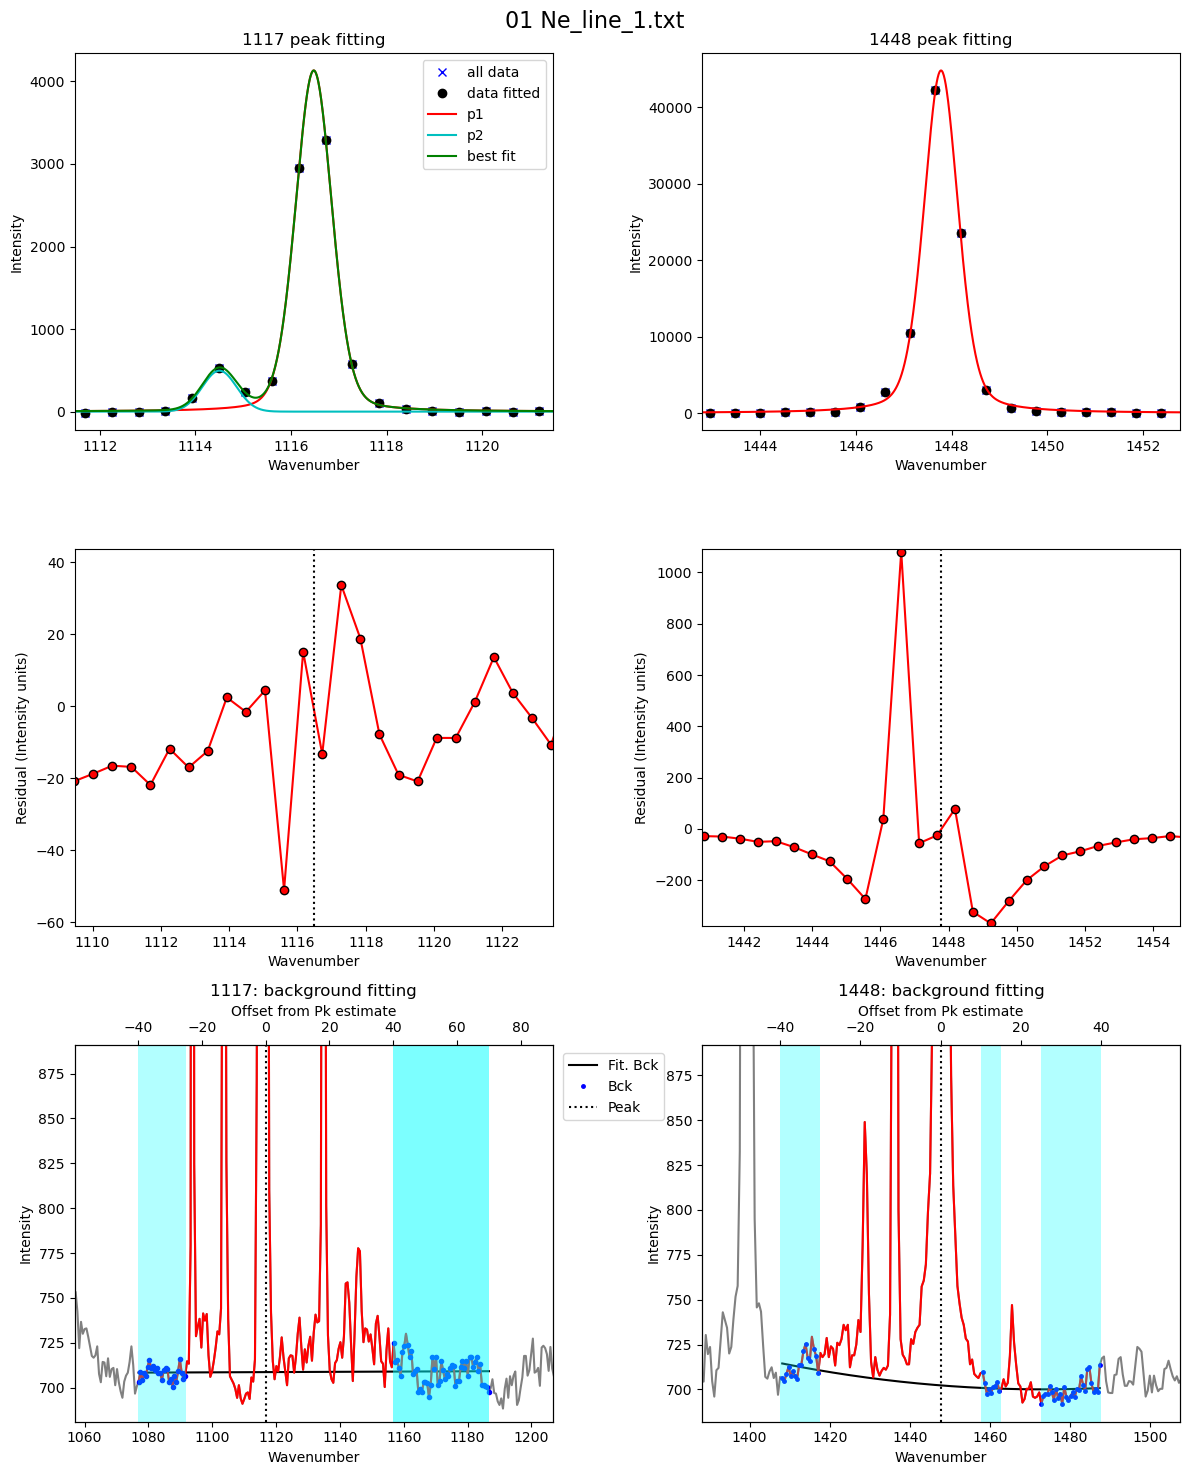

In [ ]:
df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
                                path=spectra_path, prefix=prefix,
                                config=Ne_Config_est,
                                Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
                                Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
                                Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
                                Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
                                const_params=False)                                                                 
                                                                     
display(df_test_params)

In [ ]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


##### Step 7: Loop peak finding and peak fitting parameters over all Ne files
    - Uses loop_Ne_lines to return a pandas dataframe with filename, and all peak fit parameters (including the Ne correction factor)
    - If you select plot_figure=False, the loop will be quick. 
    - But if its True, you can to inspect the figures.

  0%|          | 0/15 [00:00<?, ?it/s]

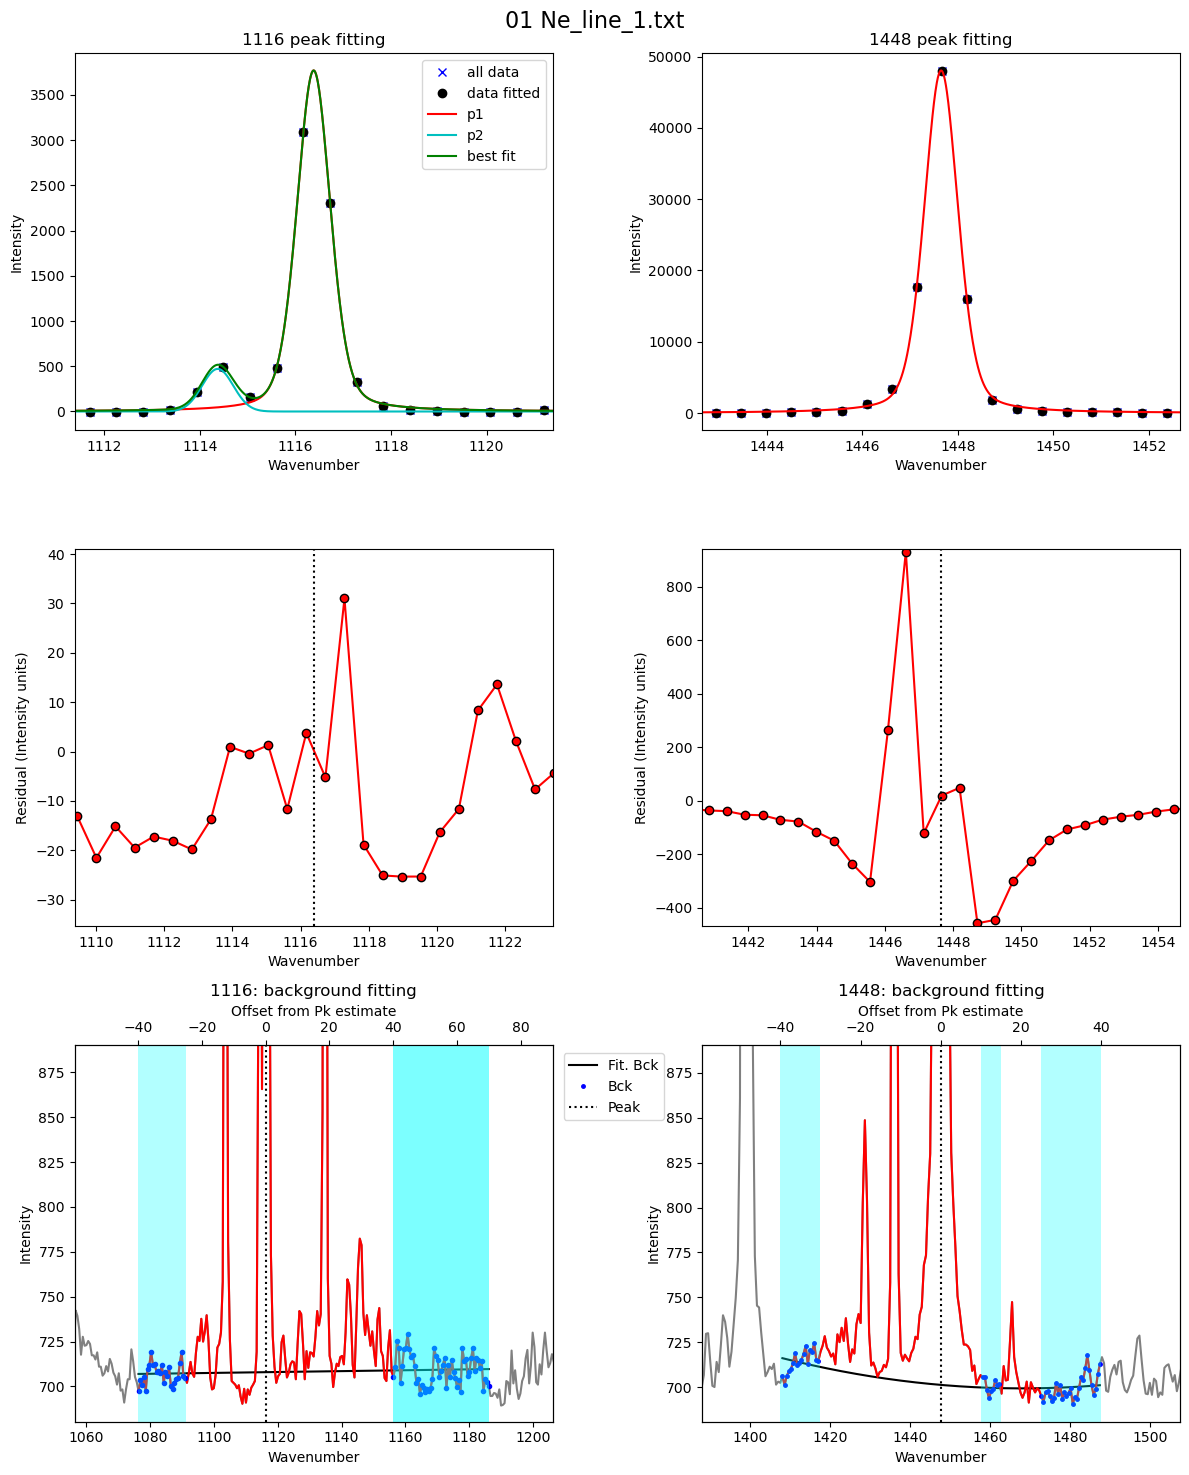

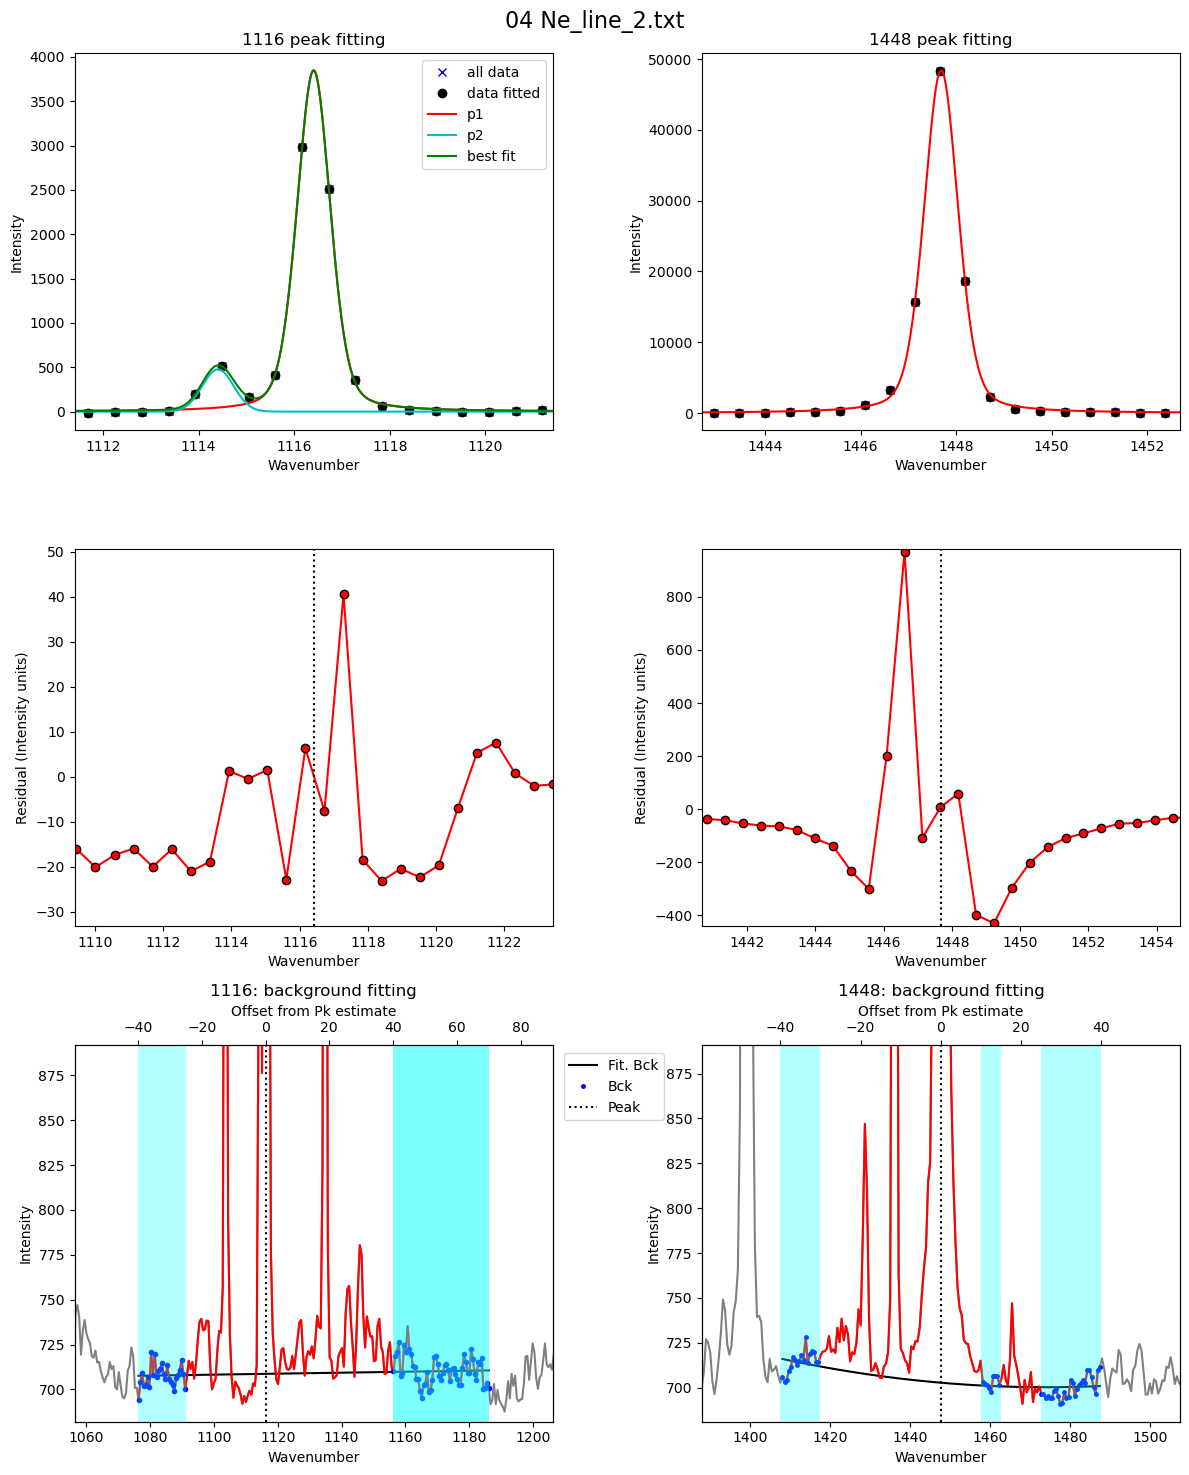

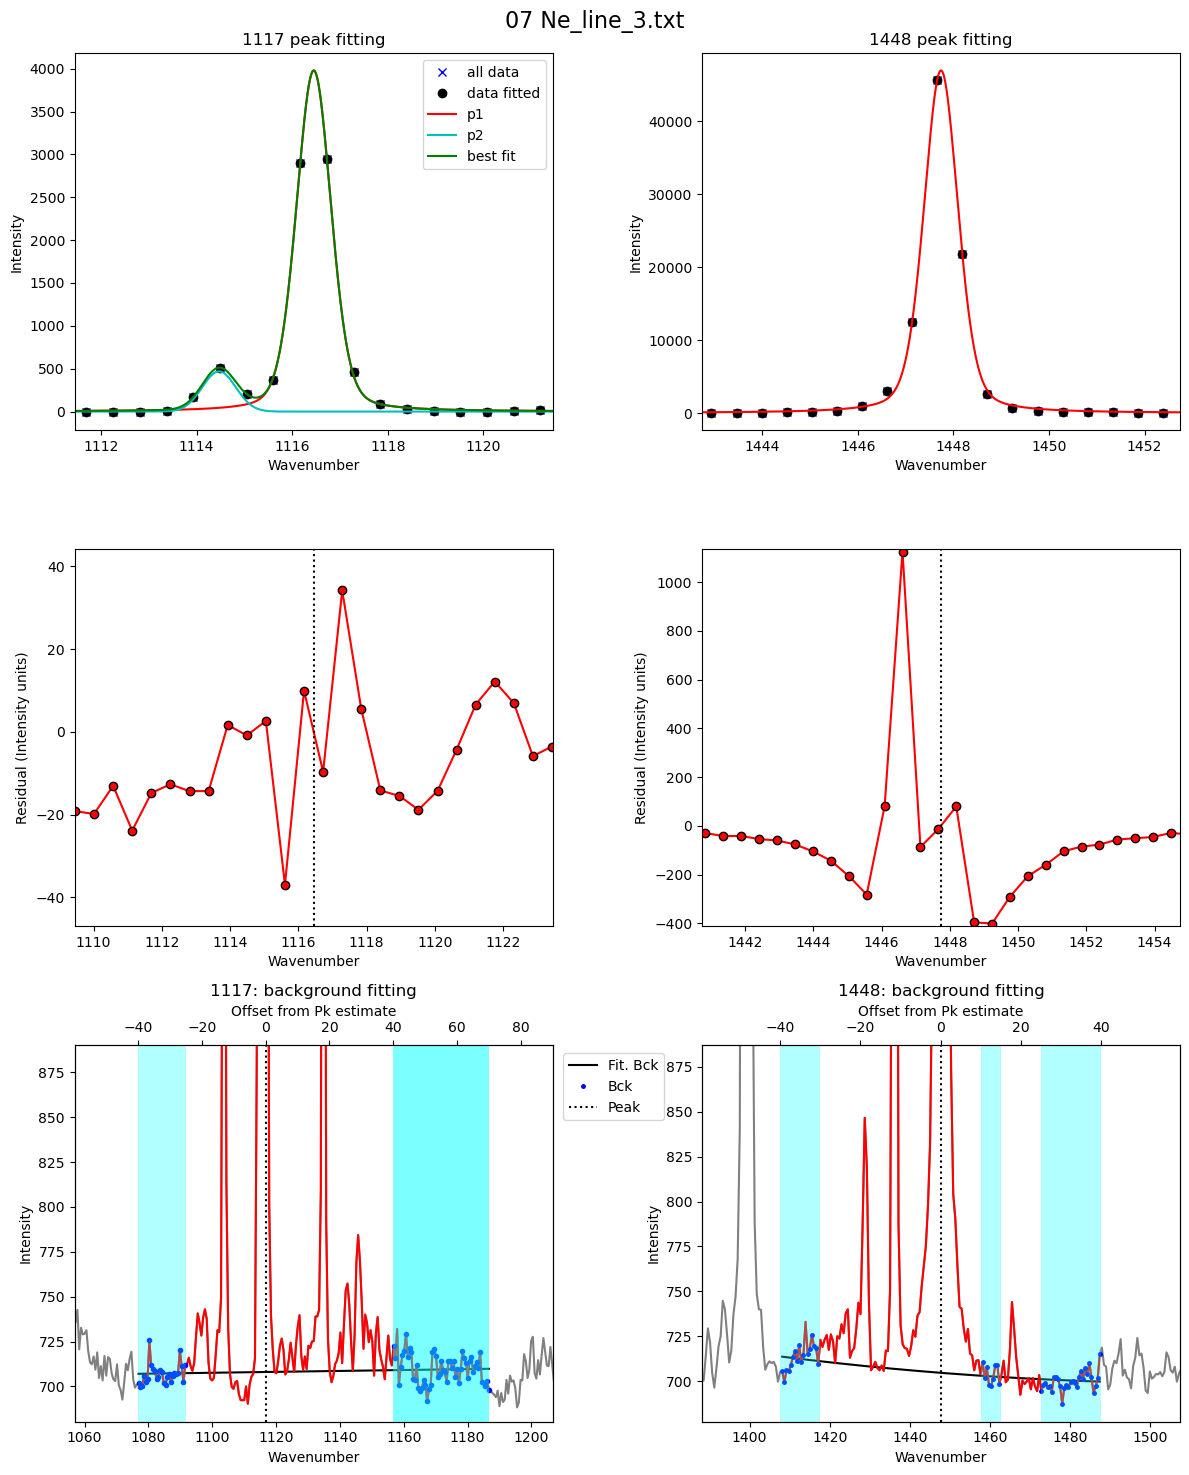

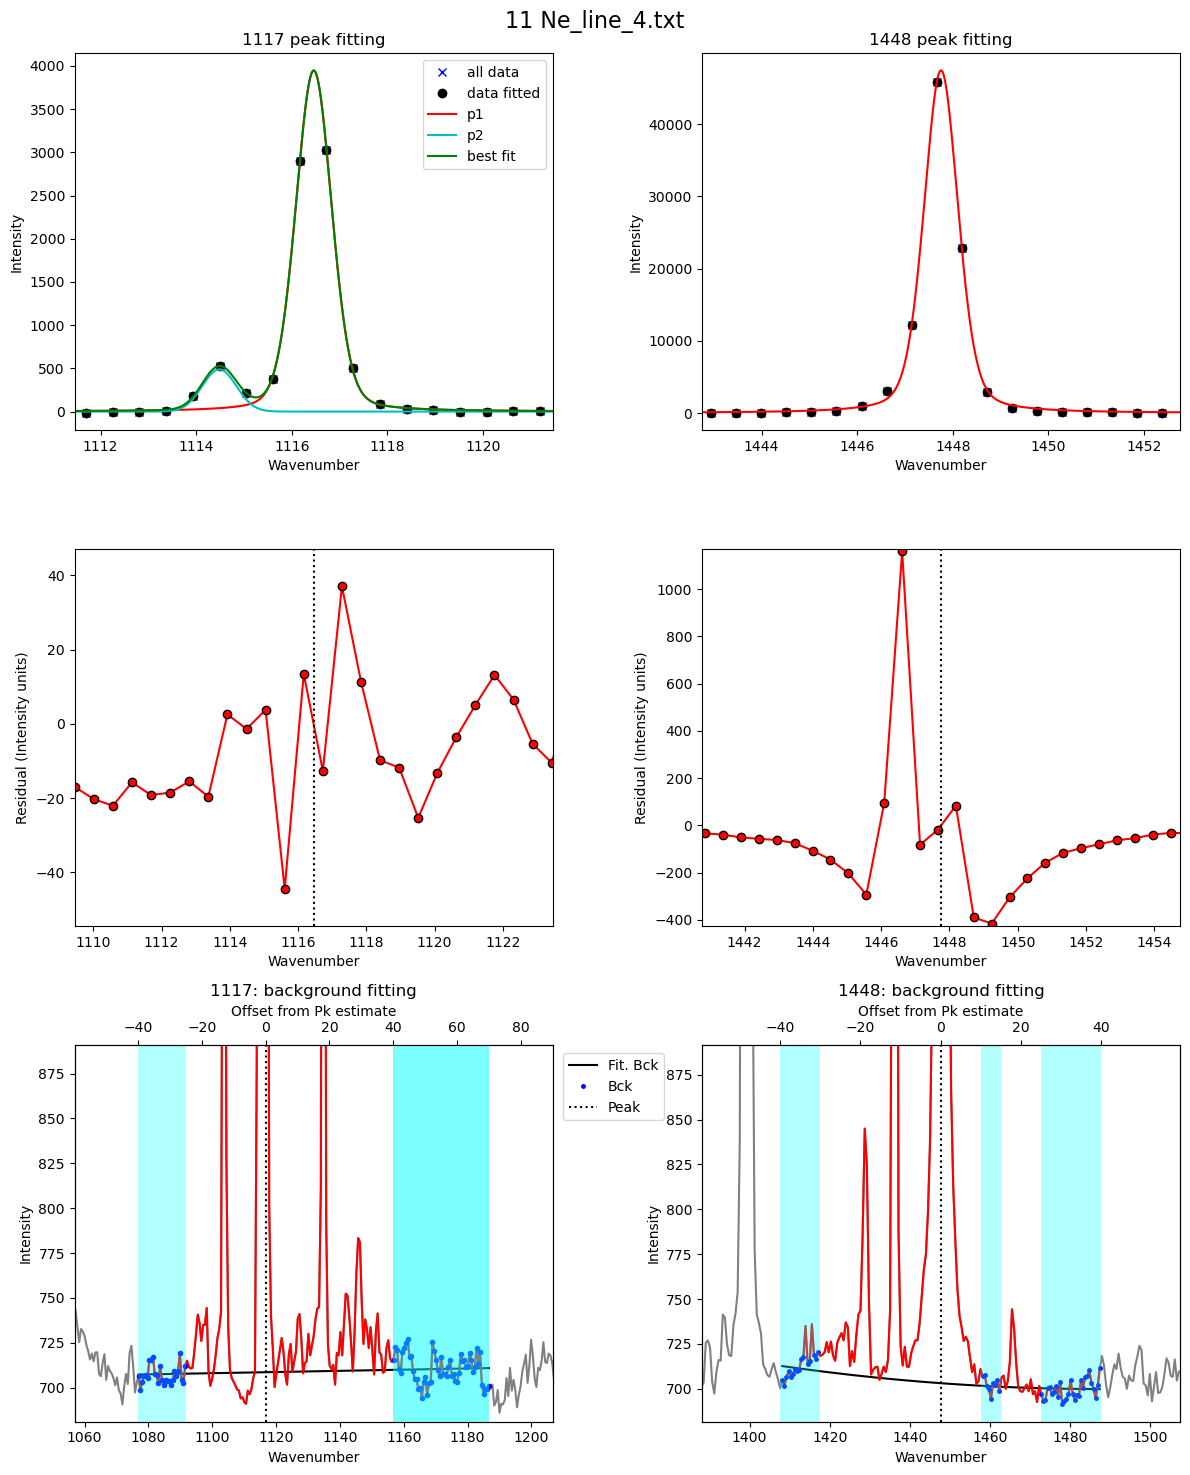

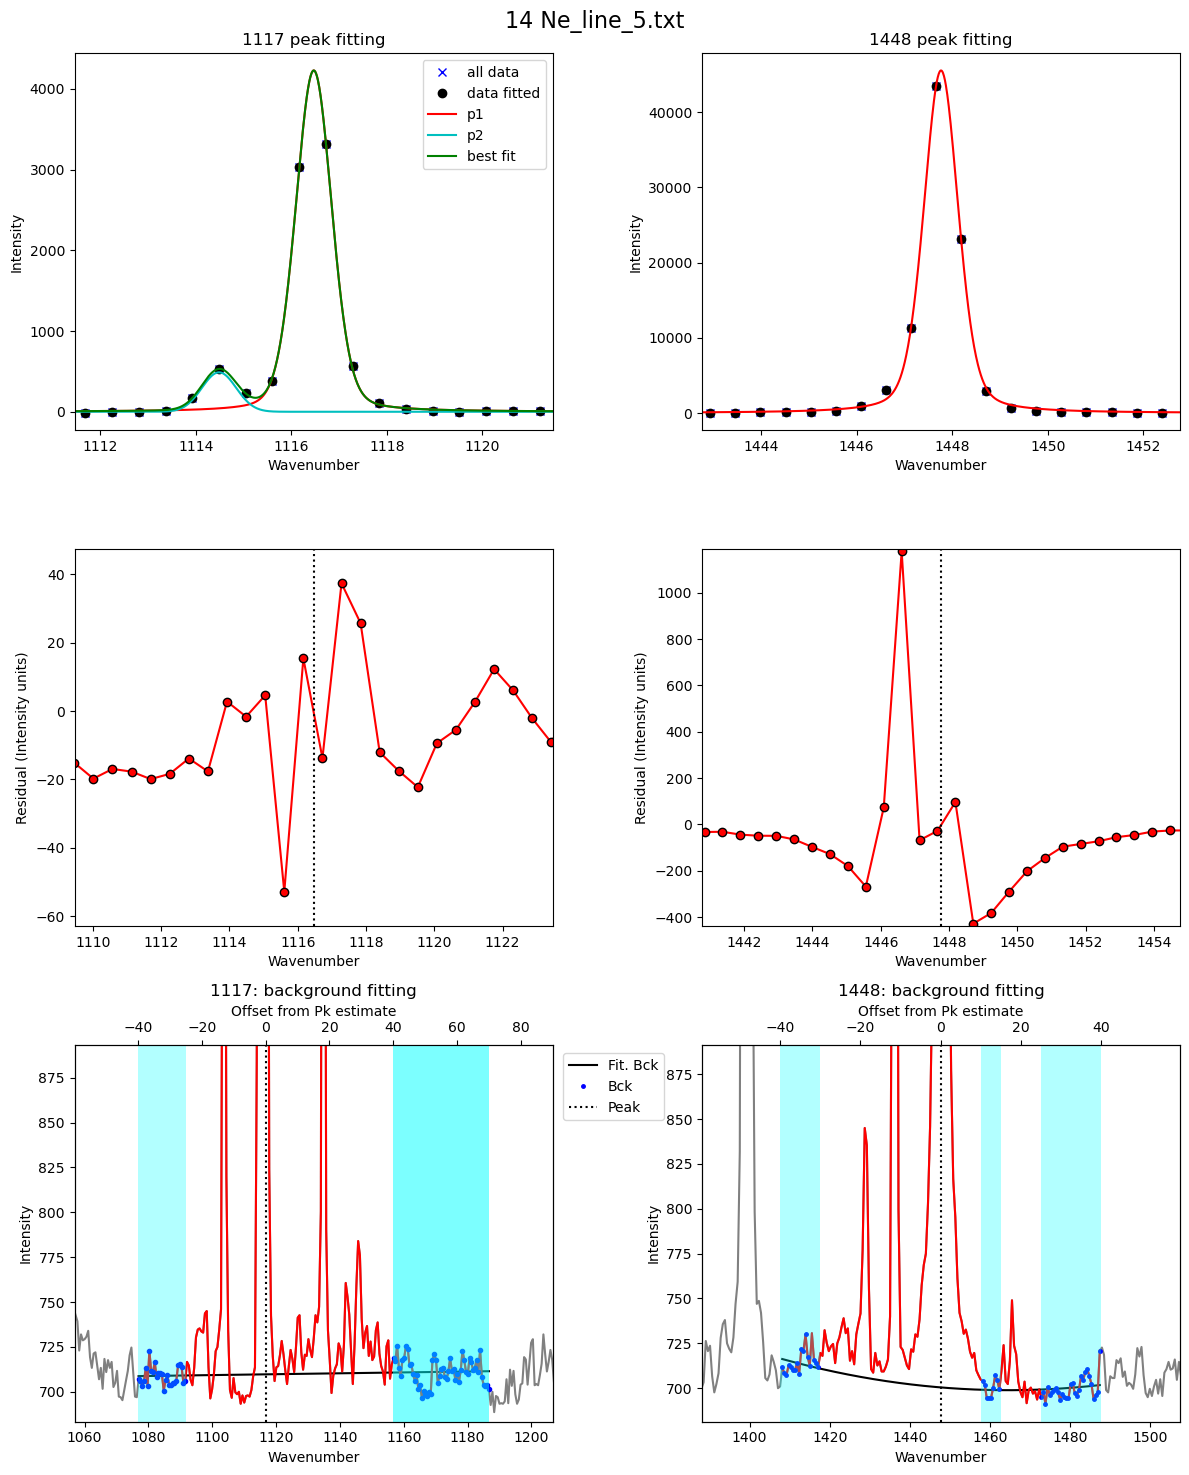

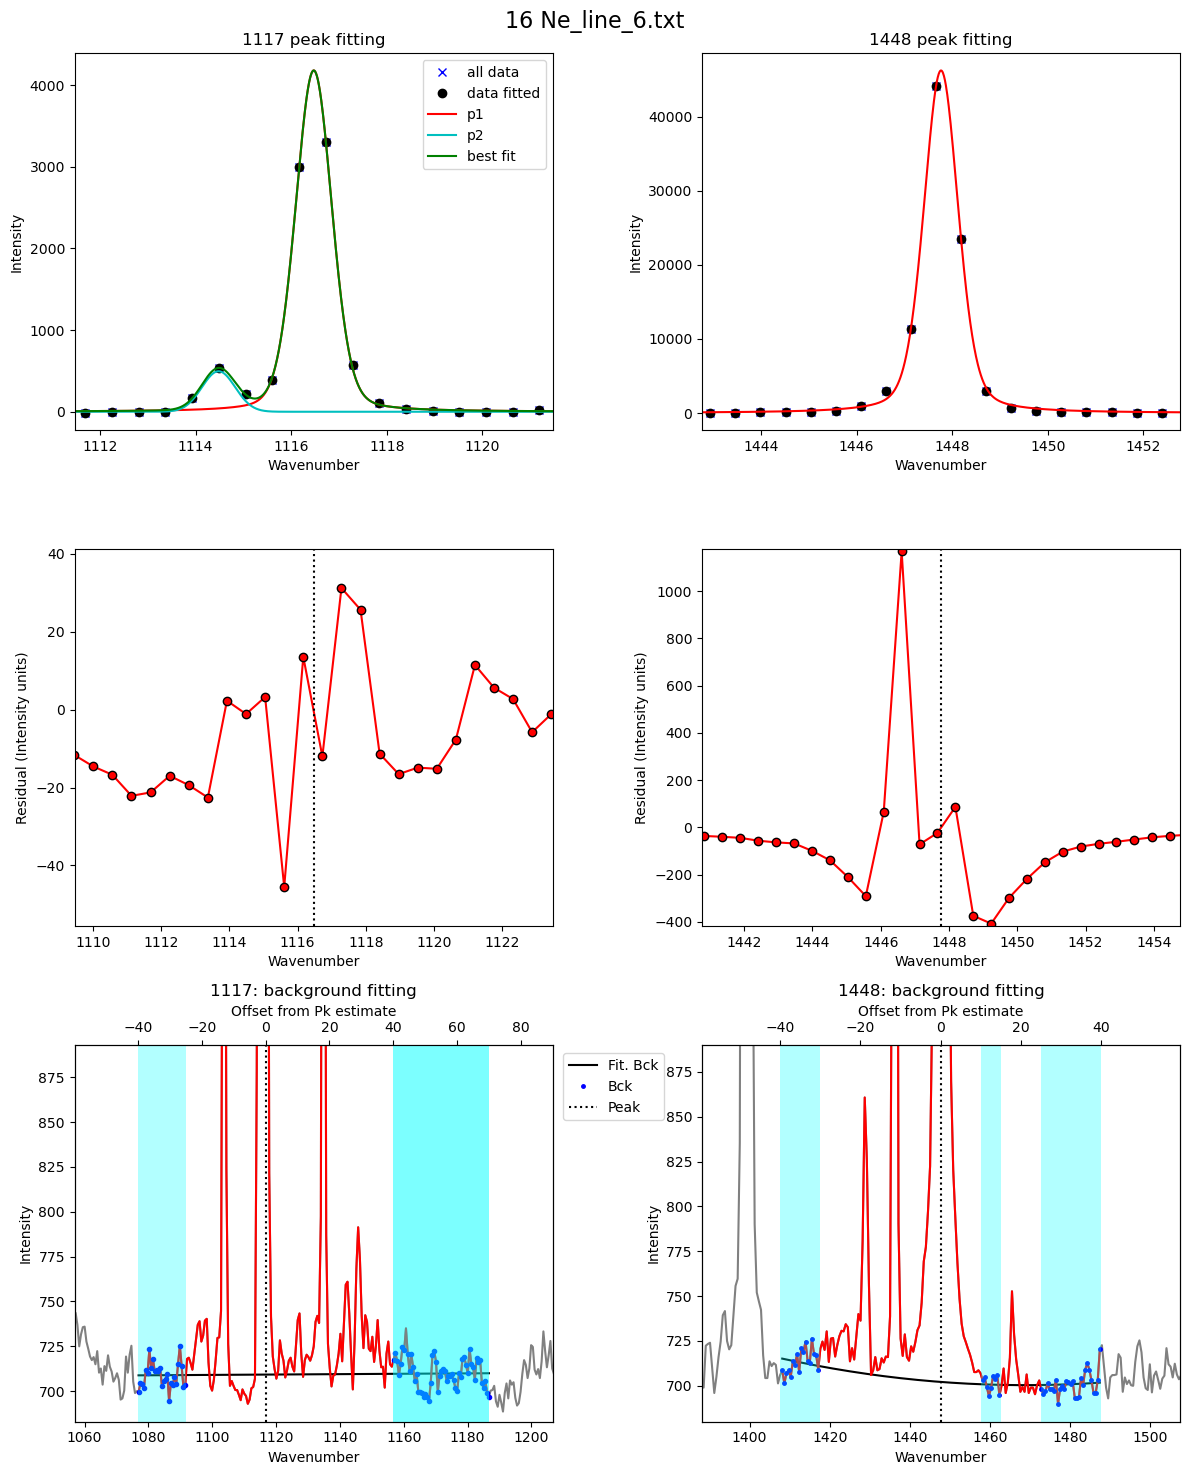

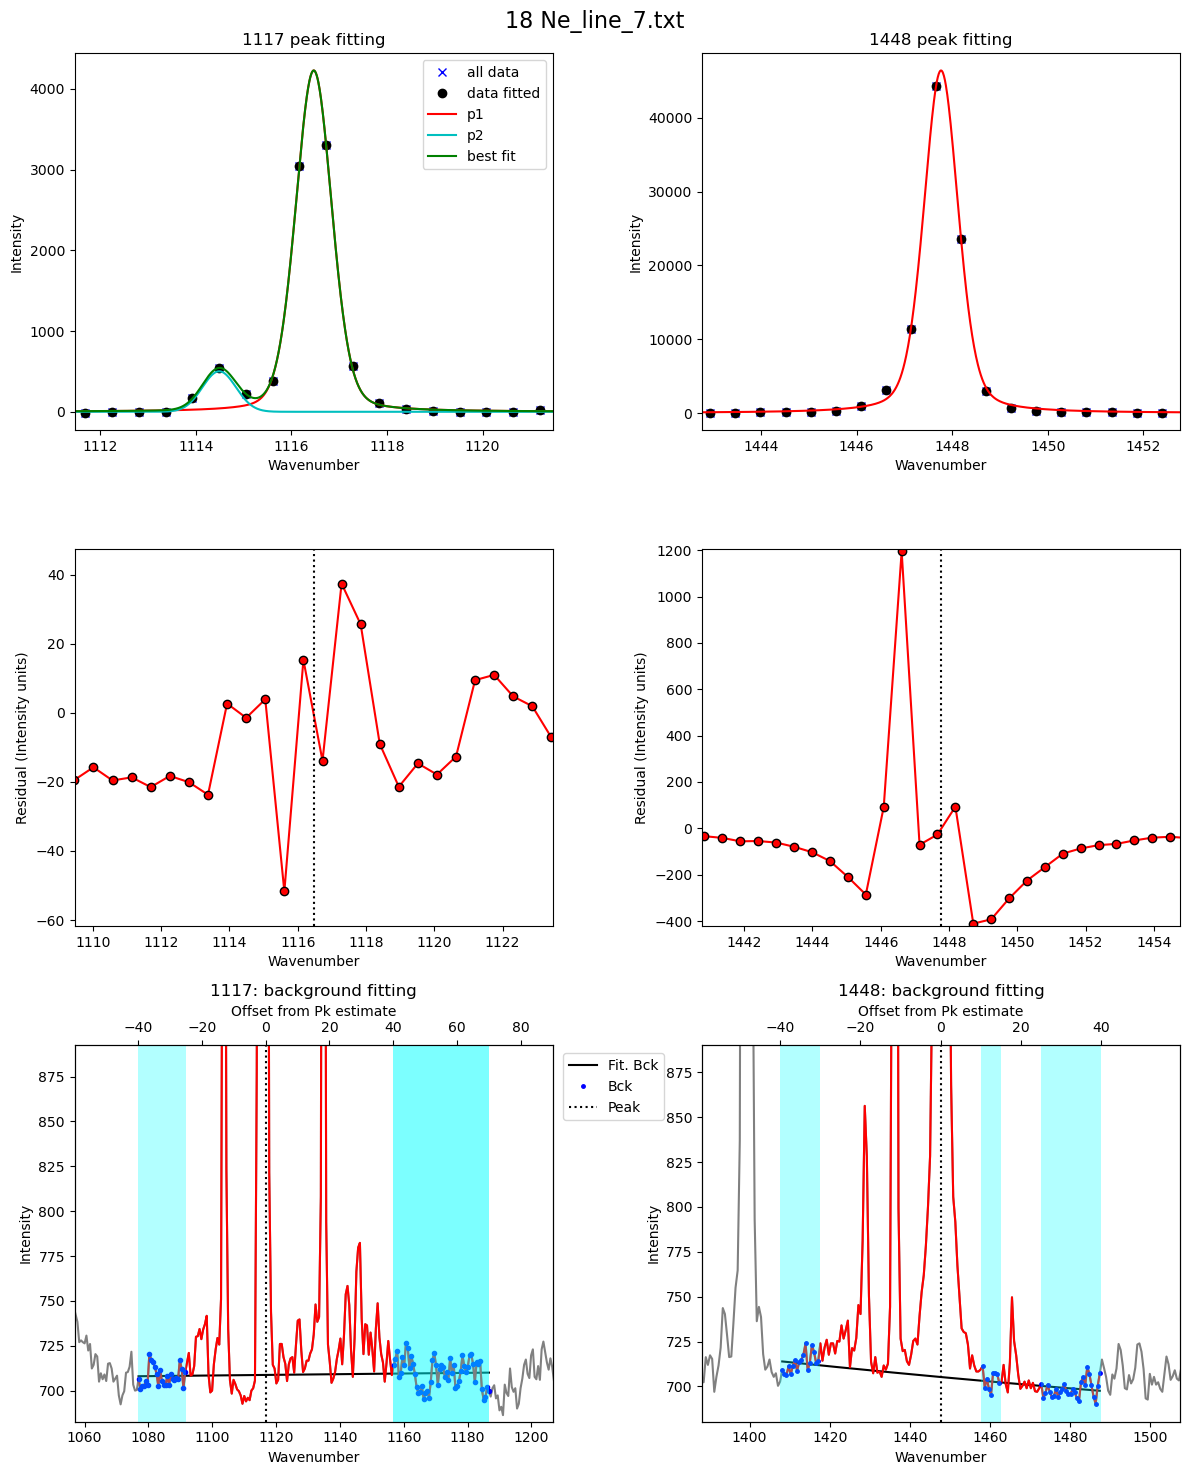

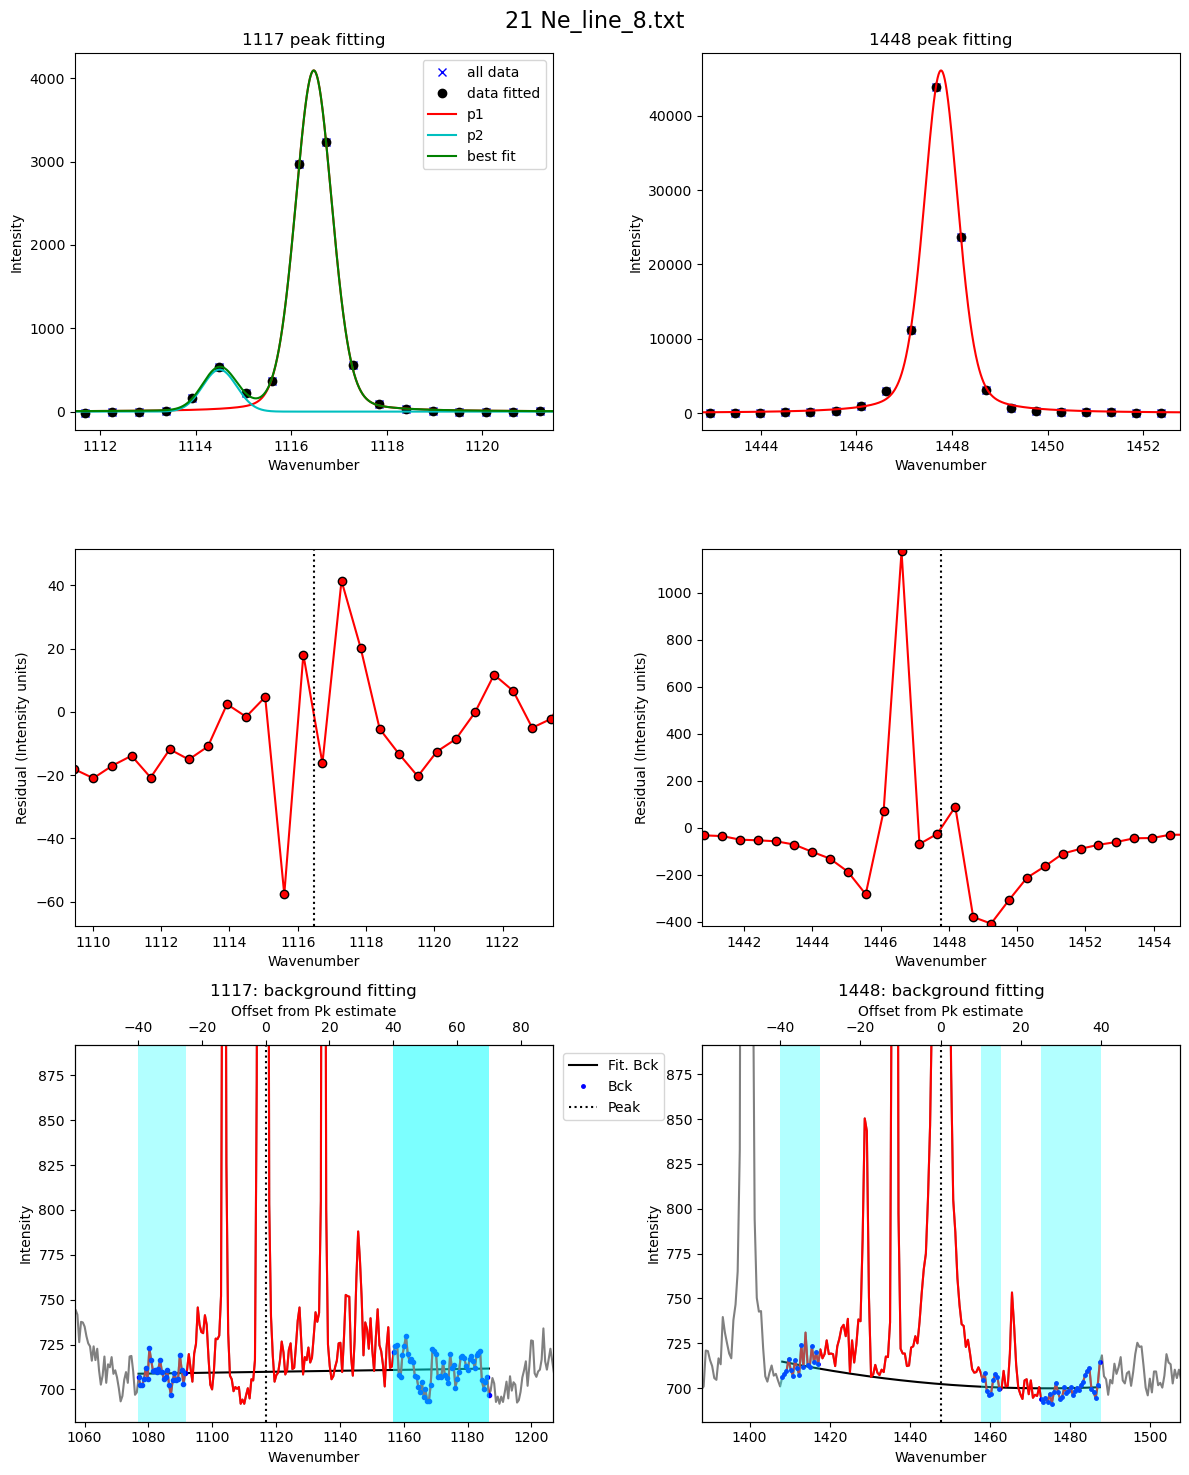

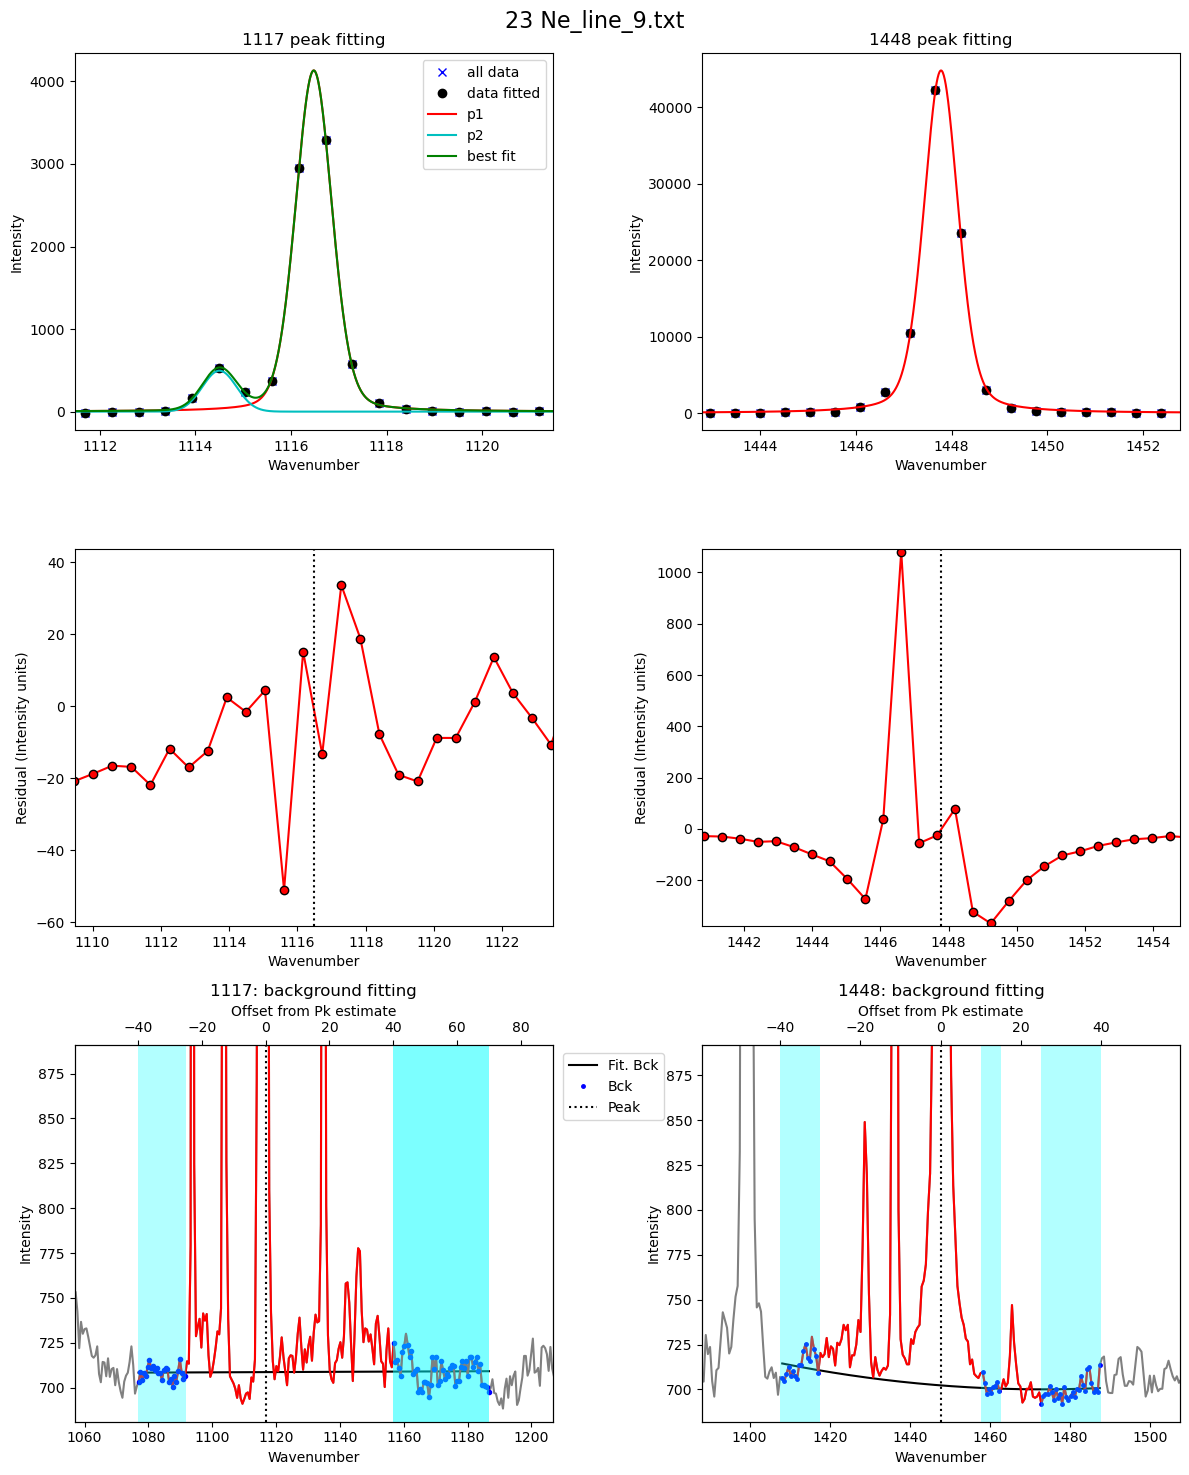

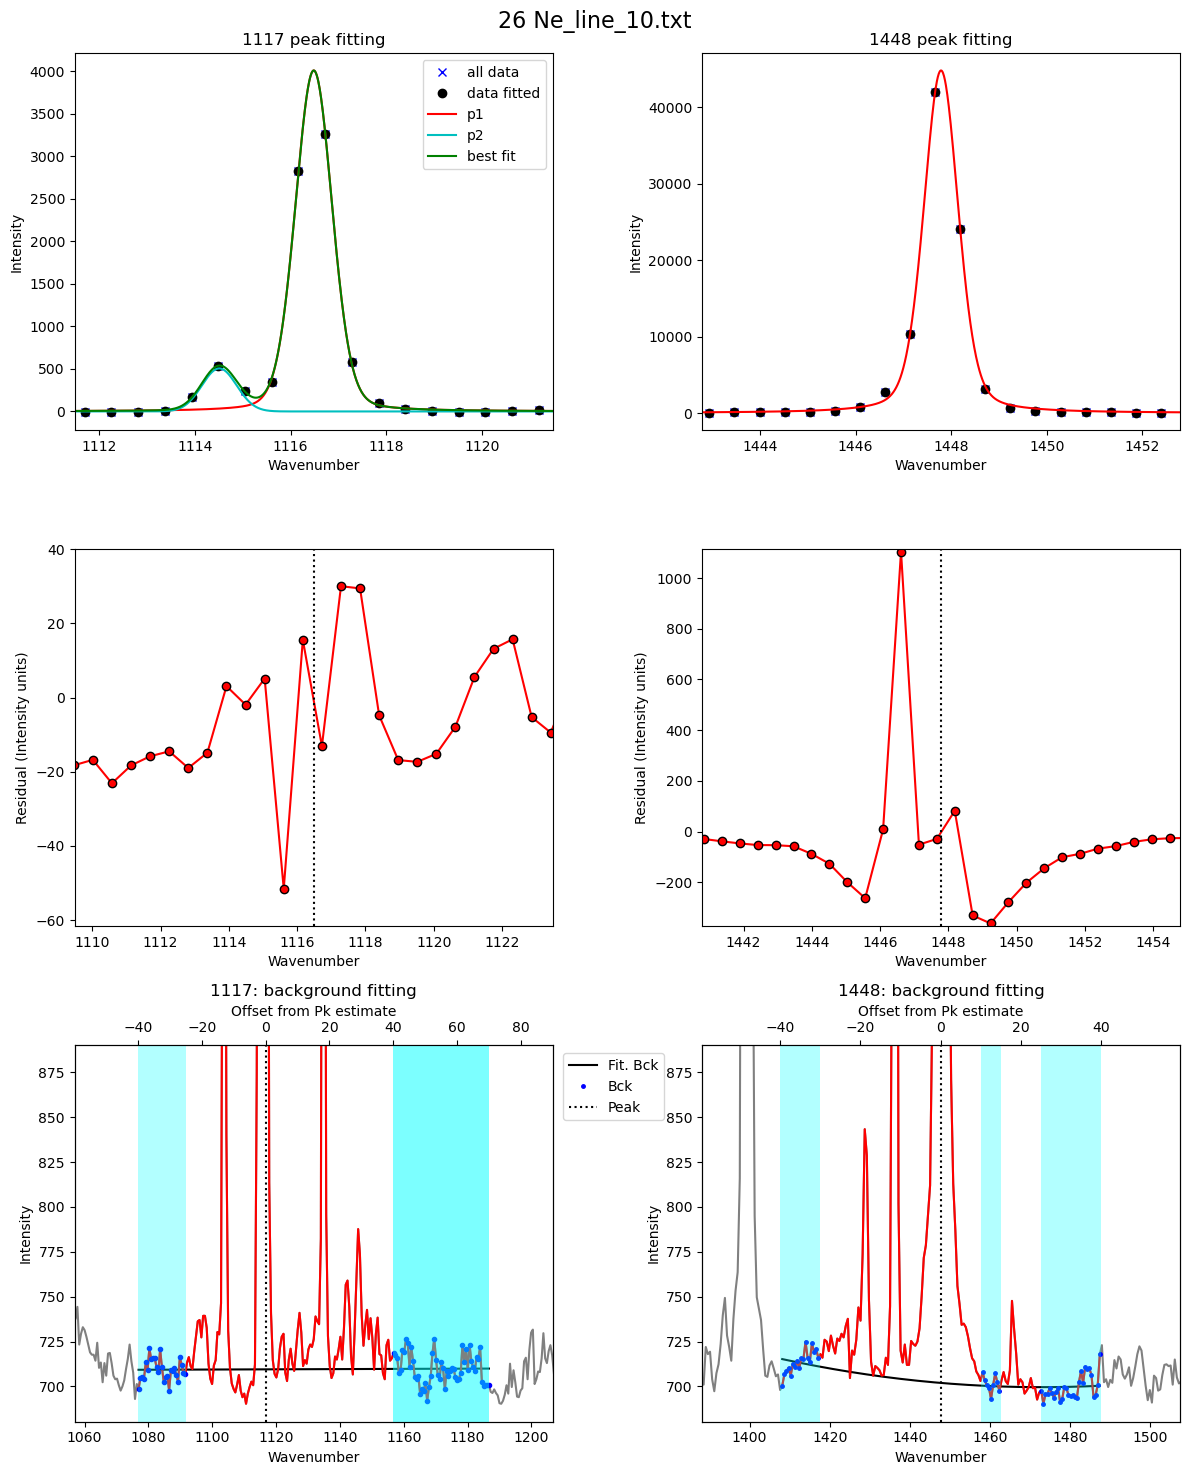

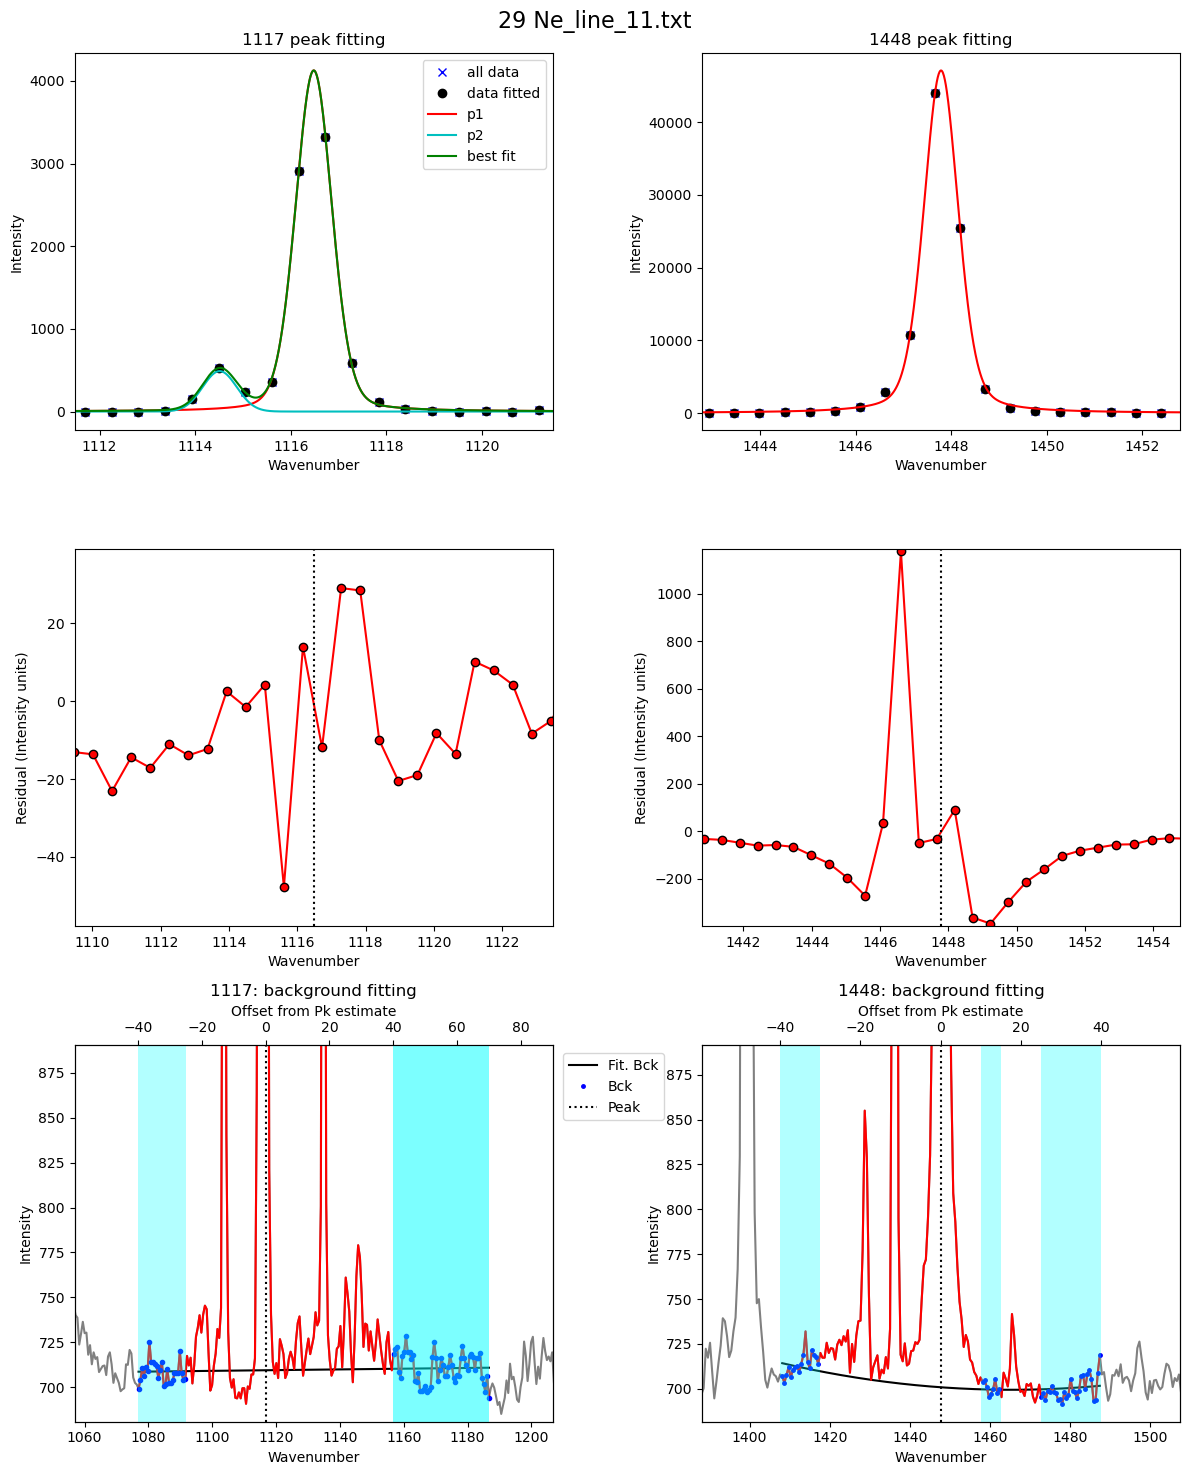

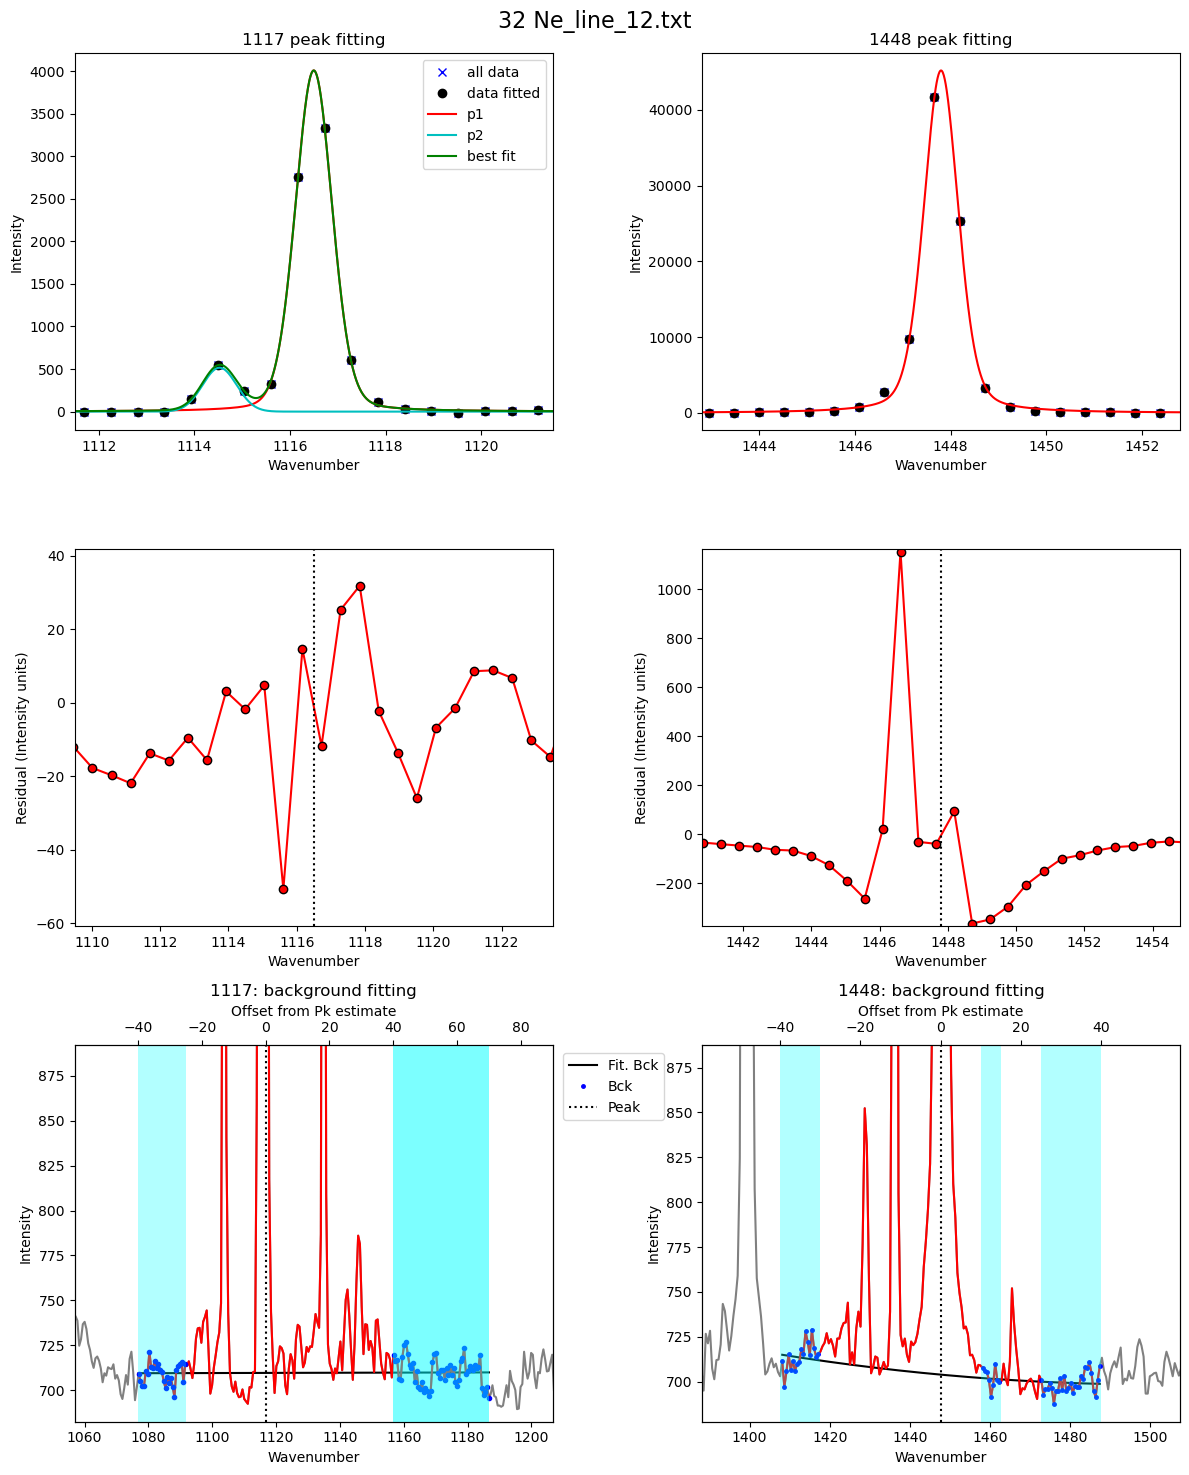

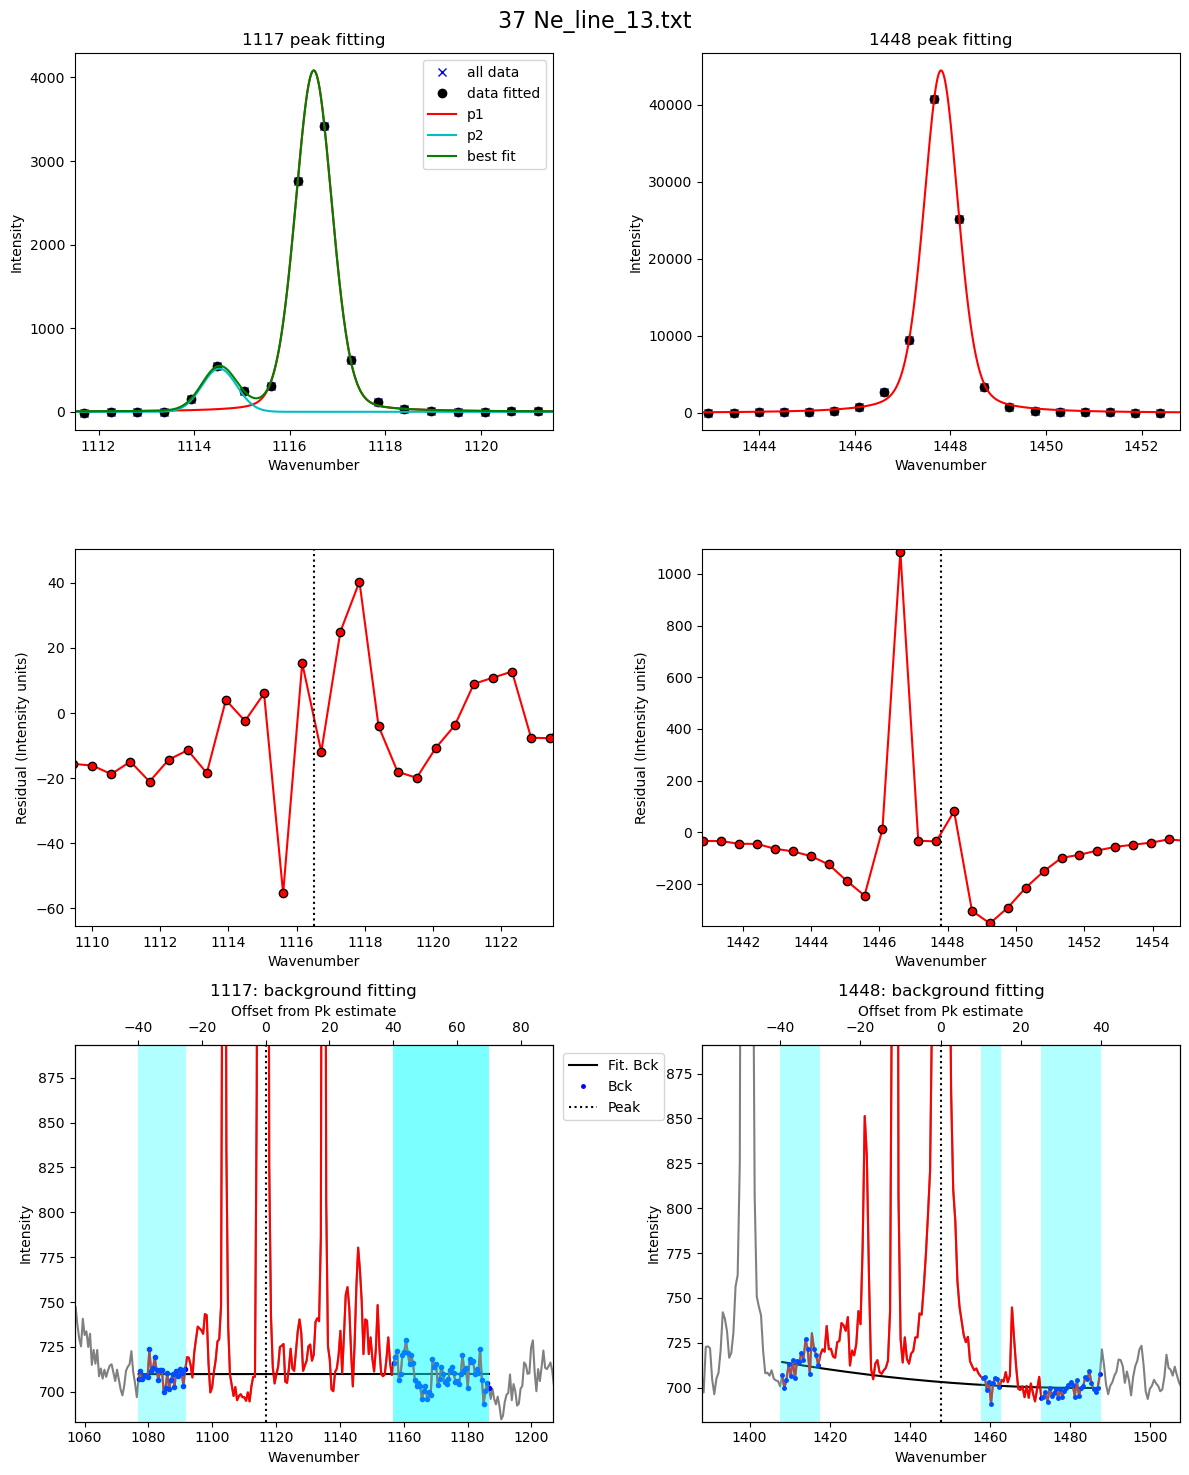

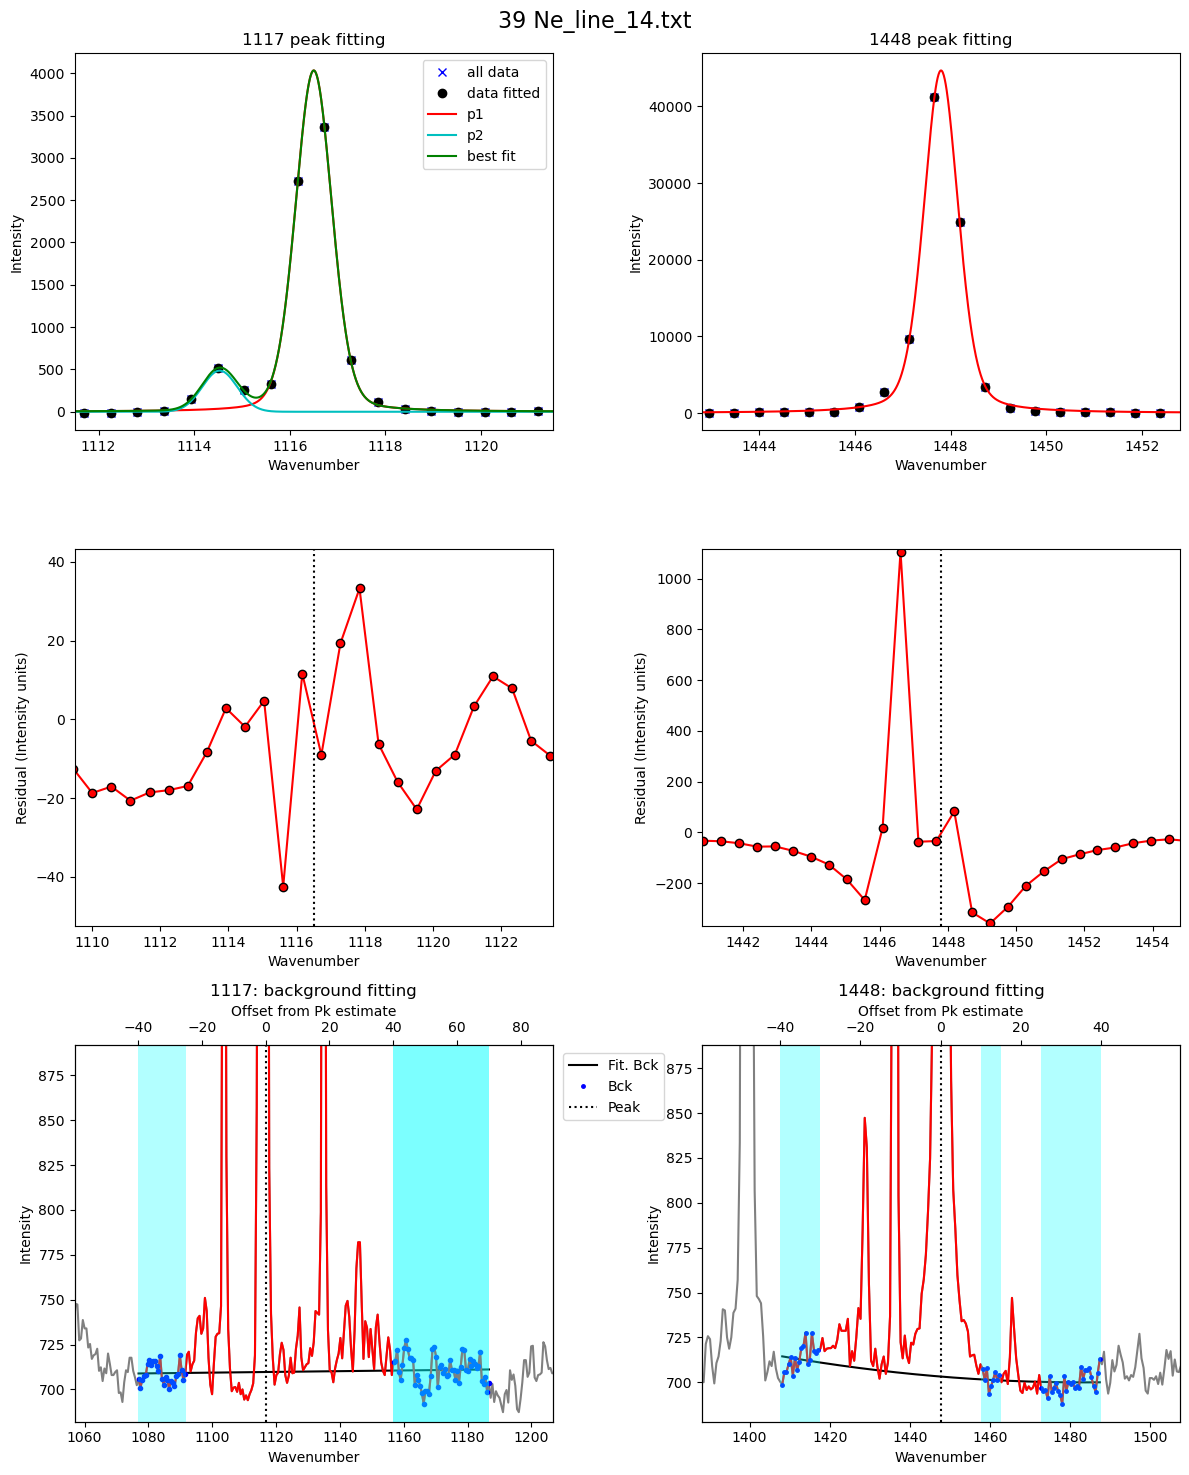

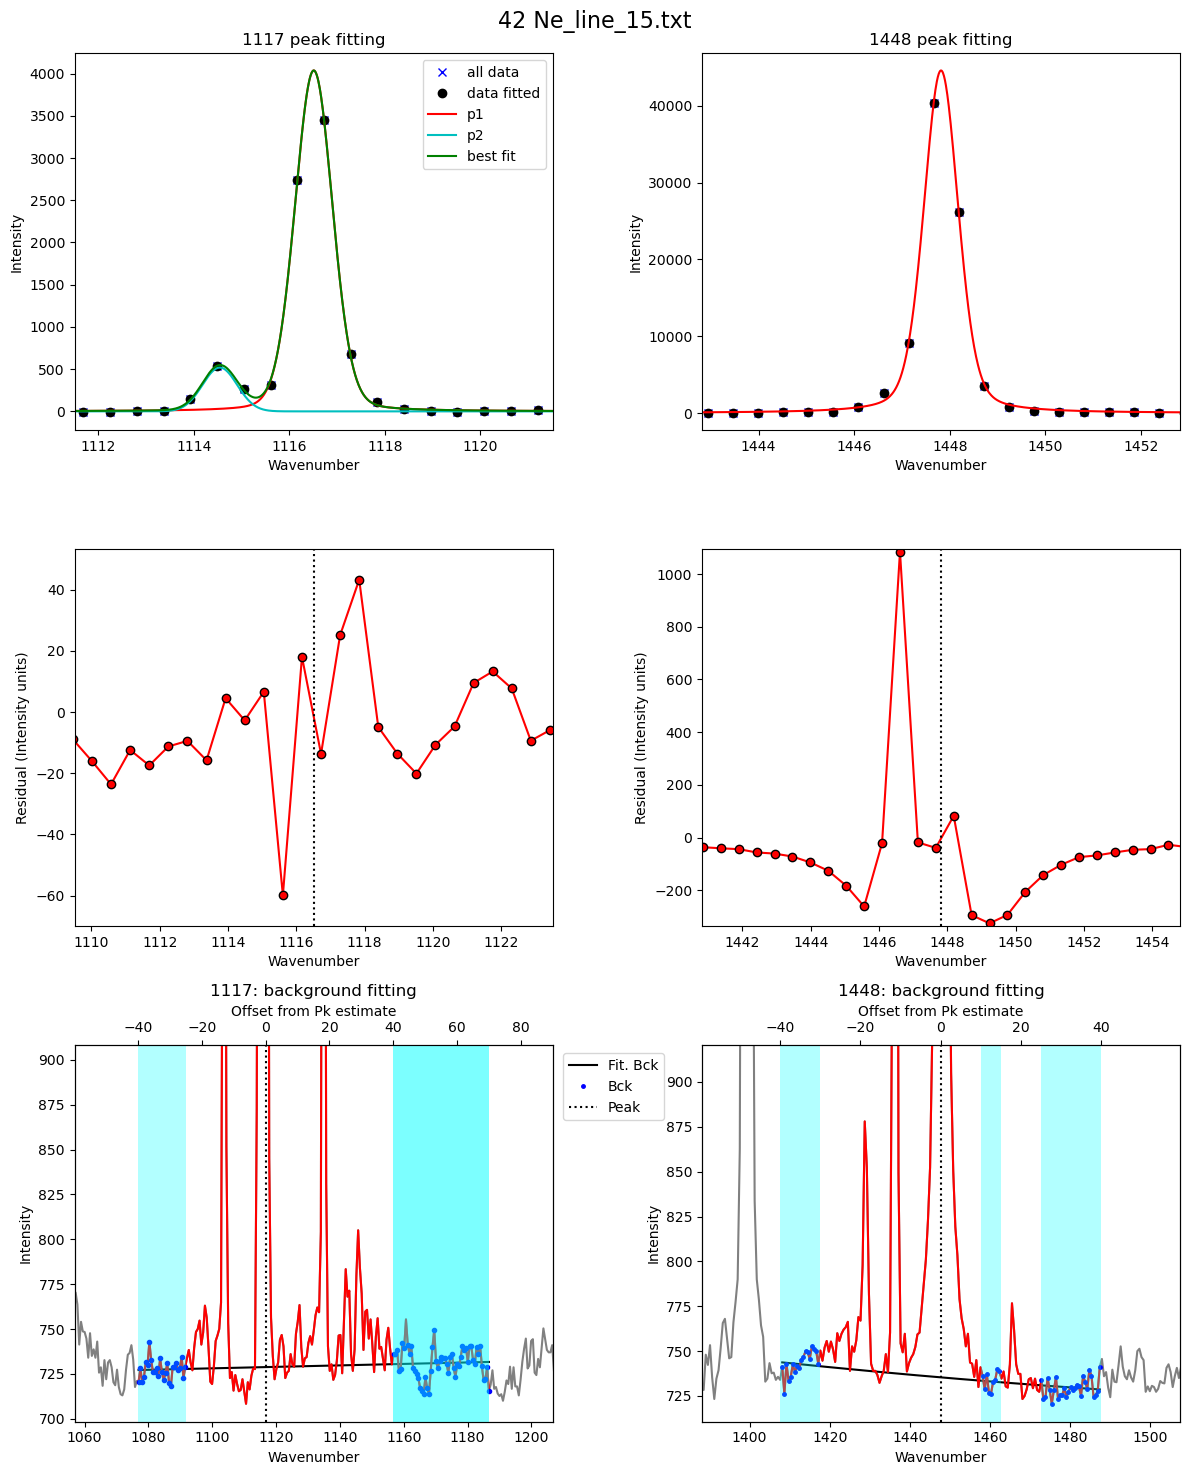

In [ ]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
                    filetype=filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
                    df_fit_params=df_fit_params,  prefix=prefix,                   
                    plot_figure=True, const_params=True)
## Use plot_figure=True if one wants to save a figure showing the fit for each file in a subfolder it creates within the spectra path
## It allows users to check fits or publish fits as part of a data repository


##### Step 8: Extract metadata to get a timestamp for each Ne file

In [ ]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['01 Ne_line_1.txt',
 '04 Ne_line_2.txt',
 '09 Ne_line_3.txt',
 '16 Ne_line_4.txt',
 '21 Ne_line_5.txt']

In [ ]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 15/15 [00:00<00:00, 123.09it/s]

Done


filename                  date      Month   Day  power (mW)  \
0  Ne_line_1.txt  September 26, 2023\n  September  26.0      11.993   
1  Ne_line_2.txt  September 26, 2023\n  September  26.0      12.144   
2  Ne_line_3.txt  September 26, 2023\n  September  26.0      12.008   
3  Ne_line_4.txt  September 26, 2023\n  September  26.0      12.027   
4  Ne_line_5.txt  September 26, 2023\n  September  26.0      12.048   

   Int_time (s)  accumulations  Mag (X)             duration      24hr_time  \
0          45.0            3.0     50.0  ['0h', '2m', '19s']   8:36:38 AM\n   
1          45.0            3.0     50.0  ['0h', '2m', '16s']   9:02:53 AM\n   
2          45.0            3.0     50.0  ['0h', '2m', '17s']   9:52:07 AM\n   
3          45.0            3.0     50.0  ['0h', '2m', '16s']  10:19:47 AM\n   
4          45.0            3.0     50.0  ['0h', '2m', '16s']  11:17:49 AM\n   

   sec since midnight  Spectral Center  
0             30998.0         1325.004  
1             32573.0         1325.004  
2             35527.0         1325.004  
3             37187.0         1325.004  
4             40669.0         1325.004

In [ ]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext='.txt')
file_m

good job, no duplicate file names


array(['Ne_line_1', 'Ne_line_2', 'Ne_line_3', 'Ne_line_4', 'Ne_line_5',
       'Ne_line_6', 'Ne_line_7', 'Ne_line_8', 'Ne_line_9', 'Ne_line_10',
       'Ne_line_11', 'Ne_line_12', 'Ne_line_13', 'Ne_line_14',
       'Ne_line_15'], dtype=object)

In [ ]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext='.txt')
file_s

good job, no duplicate file names


array(['Ne_line_1', 'Ne_line_2', 'Ne_line_3', 'Ne_line_4', 'Ne_line_5',
       'Ne_line_6', 'Ne_line_7', 'Ne_line_8', 'Ne_line_9', 'Ne_line_10',
       'Ne_line_11', 'Ne_line_12', 'Ne_line_13', 'Ne_line_14',
       'Ne_line_15'], dtype=object)

##### Combine 2 dataframes
    - Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [ ]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

##### Now lets inspect changes in Ne correction factor with time
    - Normally, you can spot outliers this way

In [ ]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

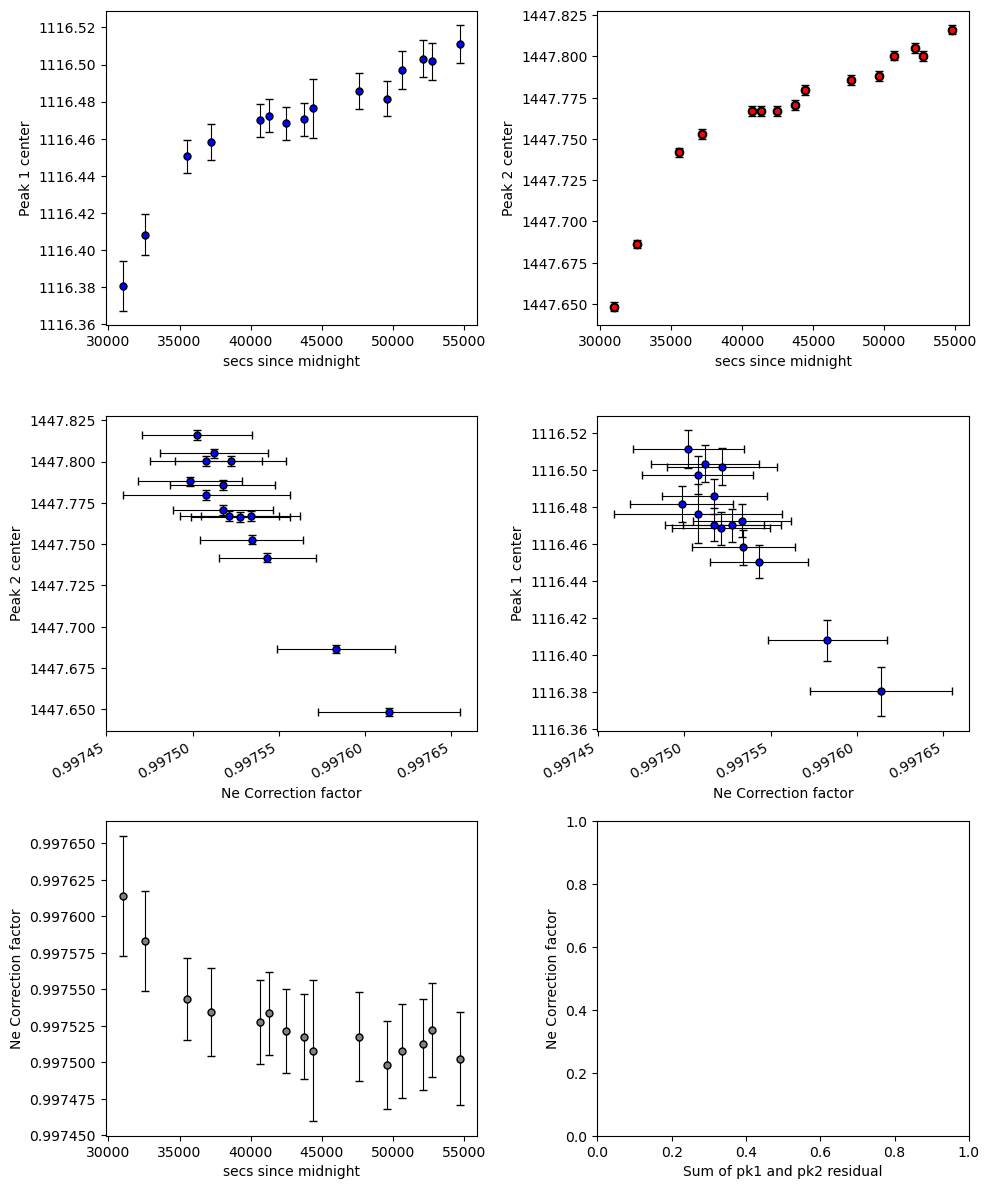

In [ ]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


##### Exclude ones that don't look right...
    - The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
    - Tweak offset and number_av until you exclude the ones that dont look right
    - Smaller number of offset - more discarded
    - If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

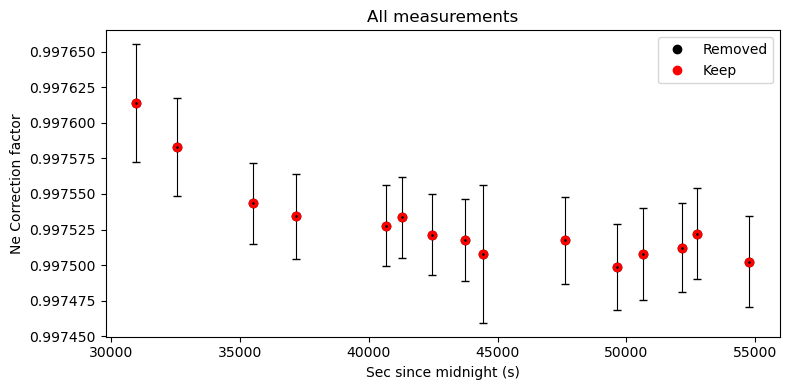

In [ ]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.00006, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

##### Now lets make a regression against time
    - We take this time regression and then apply to our diad fits
    - This regression of the correction factor as a function of time enables us to factor out random noise

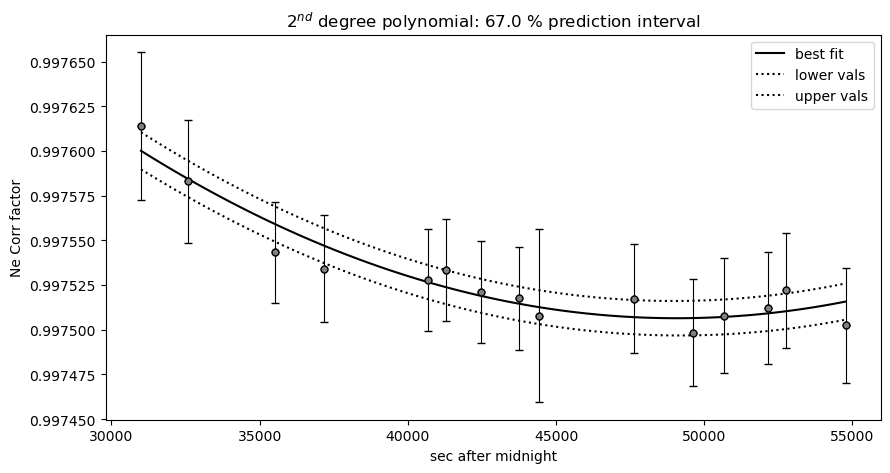

In [ ]:
## Lets get filtered ones
keep=filt>0
pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')

##### Step2_Filtering_Numerical_v66


##### Get the folder to your files
    - If this notebook is in the same folder as your files, you can use os. to get the file name. Else paste in the file name as DayFolder='C:/Penny' or whatever you use on your computer. 
    - In this case, Spectra files are stored in one subfolder called 'Spectra', Metadata files in another subfolder called 'MetaData'

In [139]:
## This reads in the previous settings you set in Step1
meta_path, spectra_path, filetype, prefix, str_prefix, file_ext, TruPower=pf.get_settings()
# dont fit files with these strings in them
exclude_str=['Ne', 'NE', 'Si', 'NoDiad', 'Spectrum', 'CRR', 'no_diad']

##### This function finds all files in your path with the specified file format
    - Specify information about your file formats here, as well as any text in filenames that you dont want to fit. 

In [205]:
Diad_Files=pf.get_files(path=spectra_path, file_ext=file_ext, exclude_str=exclude_str)
print(Diad_Files)

['05 MLP_202_MIA_Rep1.txt', '10 MLP_203_MIC_Rep2.txt', '12 MLP_203_MIC_Rep3.txt', '15 ML22_77_1_MIA.txt', '17 ML22_77_1_MIB.txt', '19 ML22_77_2_MIA_Rep1.txt', '20 ML22_77_2_MIA_Rep2.txt', '22 ML22_77_2_MIB.txt', '24 ML22_77_2_MIC.txt', '25 ML22_77_2_MID.txt', '27 ML22_77_4_MIA.txt', '30 ML22_77_5_MIB_Rep1.txt', '31 ML22_77_5_MIB_Rep2.txt', '33 ML22_88_1_MIC.txt', '35 ML22_88_1_MID_Rep2.txt', '36 ML22_88_1_MIE_Rep1.txt', '38 ML22_88_1_MIE_Rep2.txt', '40 ML22_88_1_MIF_Rep1.txt', '41 ML22_88_1_MIF_Rep2.txt']


##### Find approximate peak positions
    - Tweak Scipy parameters to find the diad peaks
    - Tweak these parameters to make sure Scipy 'find_peaks' gets your diad peaks for your instrument.
    - Prominence: most useful parameter, required prominence of peaks
    - height: Minimum height of peaks, not that useful with various background positions
    - distance: Used to help with peaks that are very close to one another, smaller distance, remove peaks until keep set distance apart
    - width: Minimum width of peaks

In [206]:
# Tweak parameters away from the default here
diad_id_config=pf.diad_id_config(prominence=50, width=1)
diad_id_config

diad_id_config(height=1, width=1, prominence=50, plot_figure=True, exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1290), Diad2_window=(1349, 1425), Diad1_window=(1245, 1320), approx_diad2_pos_3peaks=(1379, 1395, 1362))

filename  approx_split    Diad1_pos   Diad2_pos  HB1_pos  \
1  35 ML22_88_1_MID_Rep2.txt    103.084811  1286.415259  1389.50007      NaN   

   HB2_pos  C13_pos  Diad1_abs_prom  Diad2_abs_prom  HB1_abs_prom  ...  \
1      NaN      NaN       77.350885      129.806097           NaN  ...   

   HB2_height  C13_height  Diad1_height  HB1_height  Diad1_Median_Bck  \
1         NaN         NaN    780.017541         NaN        702.666657   

   Diad2_Median_Bck  C13_HB2_abs_prom_ratio  Diad2_HB2_Valley_prom  \
1        697.749985                     NaN                    NaN   

   HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
1                        NaN                        NaN  

[1 rows x 39 columns]

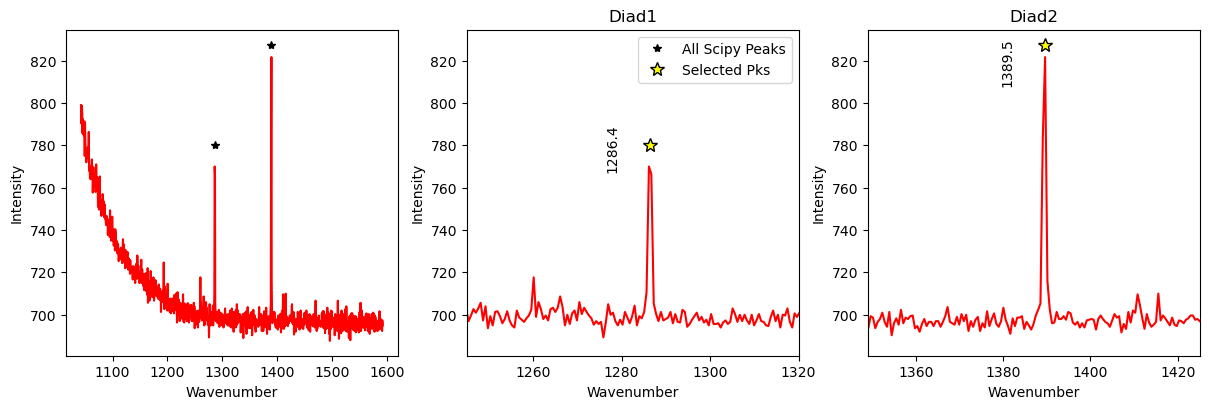

In [208]:
# Check it has found the peaks of interest. Here we are looking at the 1st file
filetype='headless_txt'
df_peaks, Diad, fig=pf.identify_diad_peaks(
config=diad_id_config, 
path=spectra_path, filename=Diad_Files[14],
filetype=filetype, plot_figure=True)
df_peaks

##### Now you have looked at a few files and are happy with these parameters, loop over all files to get approximate fit parameters for all your diad acquisitions

In [209]:
fit_params, data_y_all=pf.loop_approx_diad_fits(spectra_path=spectra_path, config=diad_id_config,  
                                                Diad_Files=Diad_Files, filetype=filetype, plot_figure=False)
fit_params.head()

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 47.15it/s]


filename  approx_split    Diad1_pos    Diad2_pos  HB1_pos  \
0  05 MLP_202_MIA_Rep1.txt    103.068312  1286.233772  1389.302084      NaN   
1  10 MLP_203_MIC_Rep2.txt    102.810311  1286.706258  1389.516569      NaN   
2  12 MLP_203_MIC_Rep3.txt    103.024315  1286.497753  1389.522068      NaN   
3     15 ML22_77_1_MIA.txt    103.051813  1286.184275  1389.236088      NaN   
4     17 ML22_77_1_MIB.txt    103.051813  1286.156777  1389.208590      NaN   

   HB2_pos  C13_pos  Diad1_abs_prom  Diad2_abs_prom  HB1_abs_prom  ...  \
0      NaN      NaN      112.923924      160.737255           NaN  ...   
1      NaN      NaN       29.000000       50.299086           NaN  ...   
2      NaN      NaN       58.912329       92.613844           NaN  ...   
3      NaN      NaN      157.074508      245.737863           NaN  ...   
4      NaN      NaN       92.175096      138.967920           NaN  ...   

   HB2_height  C13_height  Diad1_height  HB1_height  Diad1_Median_Bck  \
0         NaN         NaN    813.090611         NaN        700.166687   
1         NaN         NaN    730.333313         NaN        701.333313   
2         NaN         NaN    778.078986         NaN        719.166657   
3         NaN         NaN   1194.907821         NaN       1037.833313   
4         NaN         NaN    867.008409         NaN        774.833313   

   Diad2_Median_Bck  C13_HB2_abs_prom_ratio  Diad2_HB2_Valley_prom  \
0        700.083343                     NaN                    NaN   
1        698.749985                     NaN                    NaN   
2        717.000000                     NaN                    NaN   
3       1051.250000                     NaN                    NaN   
4        775.333313                     NaN                    NaN   

   HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
0                        NaN                        NaN  
1                        NaN                        NaN  
2                        NaN                        NaN  
3                        NaN                        NaN  
4                        NaN                        NaN  

[5 rows x 39 columns]

In [210]:
fit_params['filename']

0       05 MLP_202_MIA_Rep1.txt
1       10 MLP_203_MIC_Rep2.txt
2       12 MLP_203_MIC_Rep3.txt
3          15 ML22_77_1_MIA.txt
4          17 ML22_77_1_MIB.txt
5     19 ML22_77_2_MIA_Rep1.txt
6     20 ML22_77_2_MIA_Rep2.txt
7          22 ML22_77_2_MIB.txt
8          24 ML22_77_2_MIC.txt
9          25 ML22_77_2_MID.txt
10         27 ML22_77_4_MIA.txt
11    30 ML22_77_5_MIB_Rep1.txt
12    31 ML22_77_5_MIB_Rep2.txt
13         33 ML22_88_1_MIC.txt
14    35 ML22_88_1_MID_Rep2.txt
15    36 ML22_88_1_MIE_Rep1.txt
16    38 ML22_88_1_MIE_Rep2.txt
17    40 ML22_88_1_MIF_Rep1.txt
18    41 ML22_88_1_MIF_Rep2.txt
Name: filename, dtype: object

##### Check for duplicates

In [211]:
file_s=pf.extracting_filenames_generic(names=fit_params['filename'].reset_index(drop=True), 
    prefix=prefix, str_prefix=str_prefix,
    file_ext=file_ext)

good job, no duplicate file names


##### Filter out spectra with cosmic rays
    Pick a spectra to tweak first

35 ML22_88_1_MID_Rep2.txt


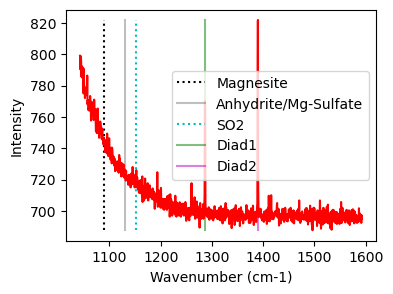

In [212]:
Diad_files=fit_params['filename']
i=14
filename_select=Diad_files.iloc[i]
print(Diad_Files[i])
plot1=pf.plot_diad(path=spectra_path, filename=filename_select, filetype=filetype)

##### Pick your other parameters

    NOTE that you can also change the number of neighbors considered in the intensity factor (n),but n=1 is often the best. dynfact is the intensity factor cutoff above which pixels are considered outliers in the first pass (y axis on the first plot on the leftmost). dynfact_2 is the same, but for the second pass. The filter automatically disregards pixels that are known to be of interest (here diads, hbs and c13).


In [214]:
# This extract the peaks for the diads, HBs and C13 from fit_params_crr, essential to the CRR process.
diad_peaks=fit_params[['Diad1_pos','Diad2_pos','HB1_pos','HB2_pos','C13_pos']]

#Pick your settings
plot_rays='rays_only'#whether to plot the results or not
export_cleanspec=True #whether to export the spectra with the cosmic ray pixels removed
save_fig='all' #whether to save the figures, options are 'all' or the default 'rays_only'
dynfact=0.001 #dynamic intensity factor for the first pass (y axis on the leftmost plots)
dynfact_2=0.001#dynamic intensity factor for the second pass
n=1 # number of neighboring pixels being compared, typically 1 is ideal.

exclude_ranges=[(1100,1200)] # List of tuples containing ranges to exclude from filtering (i.e., for secondary peaks

##### Run the filter on the selected spectra
    - rays_found is a dataframe containing the filename and whether cosmic rays were found. spectrum is the filtered spectrum in the form of a dataframe. 
    - It contains nan values where the cosmic rays are. It is NOT for fitting.

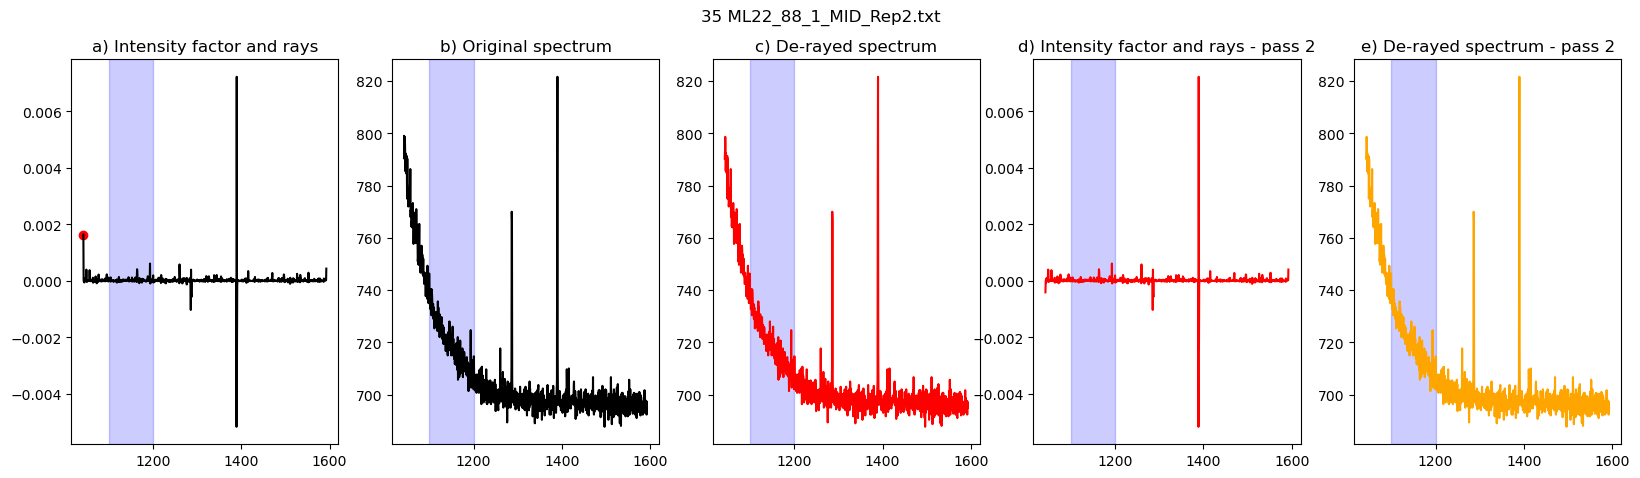

In [215]:
rays_found,spectrum=pf.cosmicray_filter.filter_singleray(path=spectra_path,
                                        exclude_ranges=exclude_ranges,filetype=filetype,
                                        Diad_files=Diad_files,i=i,diad_peaks=diad_peaks,plot_rays=plot_rays,
                                      export_cleanspec=export_cleanspec,save_fig=save_fig,dynfact=dynfact,dynfact_2=dynfact_2,n=n)


#####  Loop over all other spectra
    the output of this is the data_y_all file, which contains plottable spectra and the new fit_params file with filtered spectra

100%|██████████| 19/19 [00:00<00:00, 31.79it/s]


filename rays_present  approx_split    Diad1_pos  \
0           05 MLP_202_MIA_Rep1.txt        False    103.068312  1286.233772   
1           10 MLP_203_MIC_Rep2.txt        False    102.810311  1286.706258   
2           12 MLP_203_MIC_Rep3.txt        False    103.024315  1286.497753   
3  15 ML22_77_1_MIA_CRR_DiadFit.txt         True    103.051813  1286.184275   
4              17 ML22_77_1_MIB.txt        False    103.051813  1286.156777   

     Diad2_pos  HB1_pos  HB2_pos  C13_pos  Diad1_abs_prom  Diad2_abs_prom  \
0  1389.302084      NaN      NaN      NaN      112.923924      160.737255   
1  1389.516569      NaN      NaN      NaN       29.000000       50.299086   
2  1389.522068      NaN      NaN      NaN       58.912329       92.613844   
3  1389.236088      NaN      NaN      NaN      157.074508      245.737863   
4  1389.208590      NaN      NaN      NaN       92.175096      138.967920   

   ...  HB2_height  C13_height  Diad1_height  HB1_height  Diad1_Median_Bck  \
0  ...         NaN         NaN    813.090611         NaN        700.166687   
1  ...         NaN         NaN    730.333313         NaN        701.333313   
2  ...         NaN         NaN    778.078986         NaN        719.166657   
3  ...         NaN         NaN   1194.907821         NaN       1037.833313   
4  ...         NaN         NaN    867.008409         NaN        774.833313   

   Diad2_Median_Bck  C13_HB2_abs_prom_ratio  Diad2_HB2_Valley_prom  \
0        700.083343                     NaN                    NaN   
1        698.749985                     NaN                    NaN   
2        717.000000                     NaN                    NaN   
3       1051.250000                     NaN                    NaN   
4        775.333313                     NaN                    NaN   

   HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
0                        NaN                        NaN  
1                        NaN                        NaN  
2                        NaN                        NaN  
3                        NaN                        NaN  
4                        NaN                        NaN  

[5 rows x 40 columns]

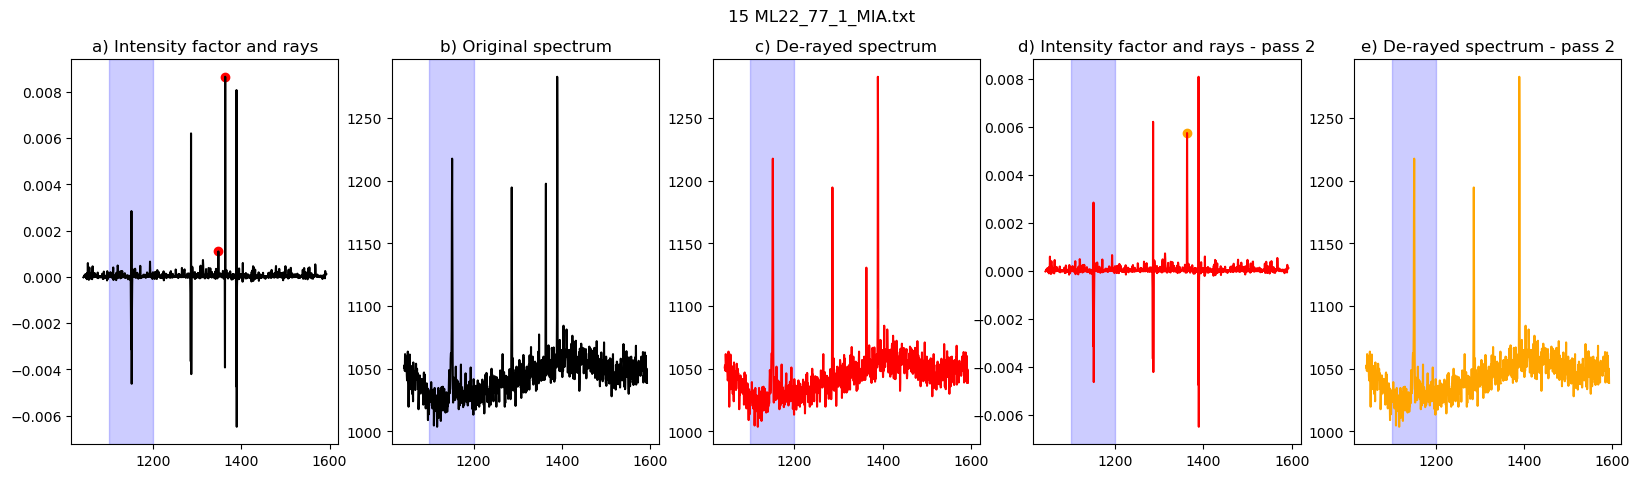

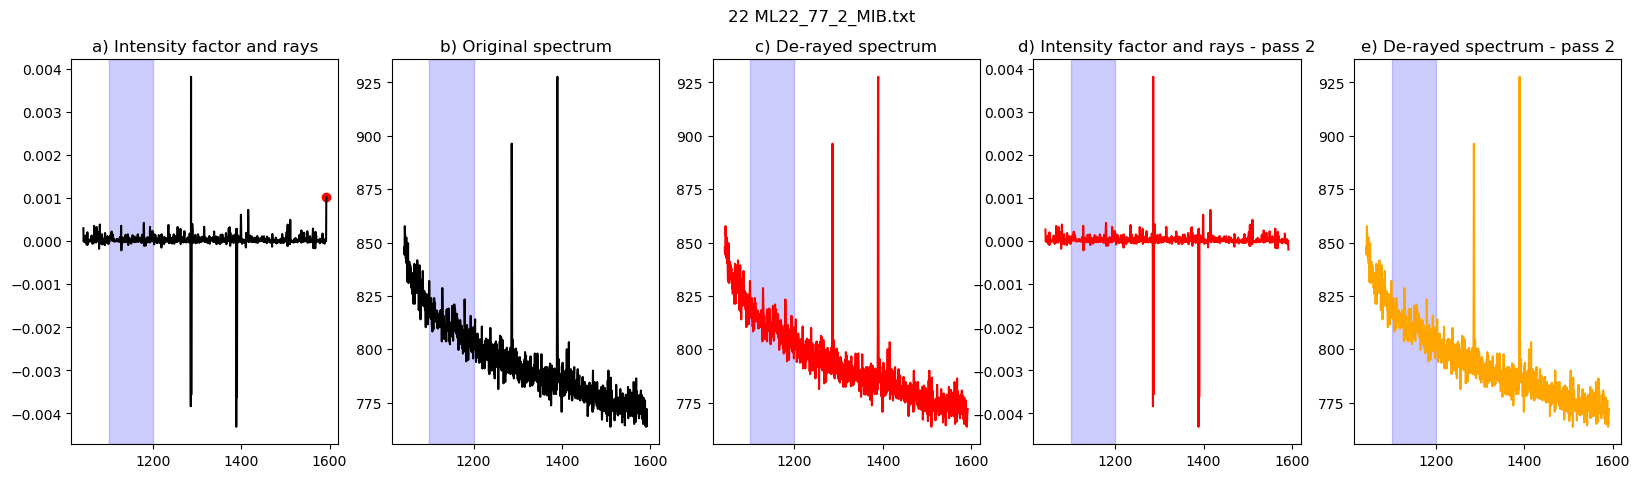

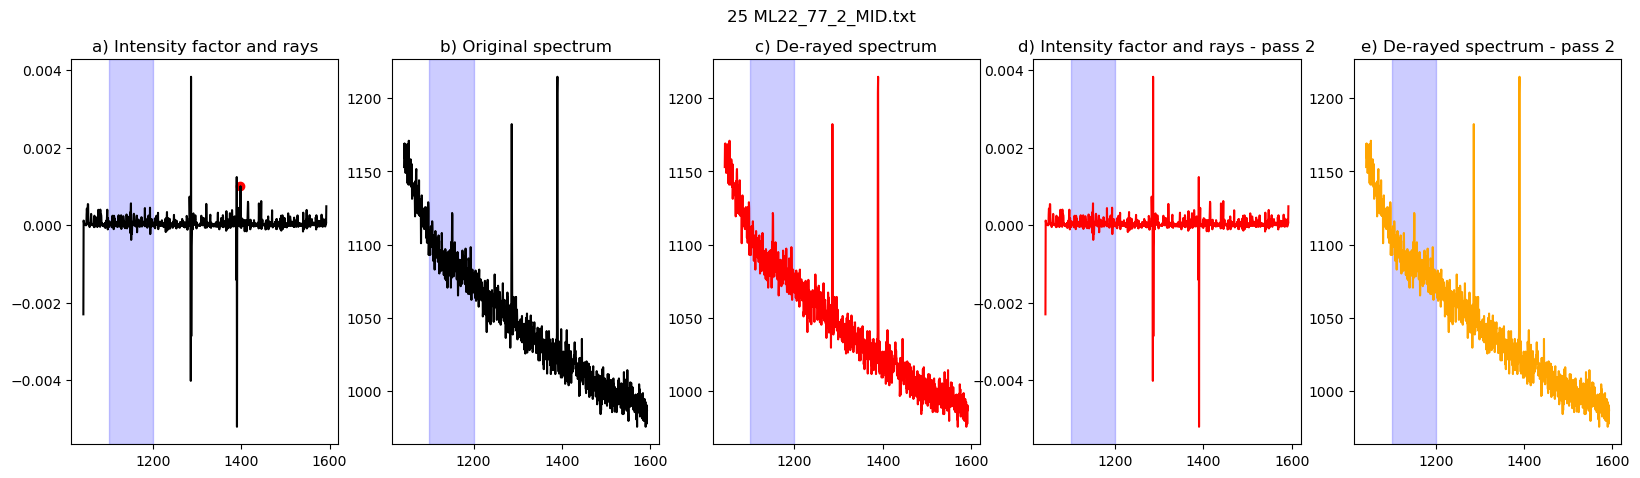

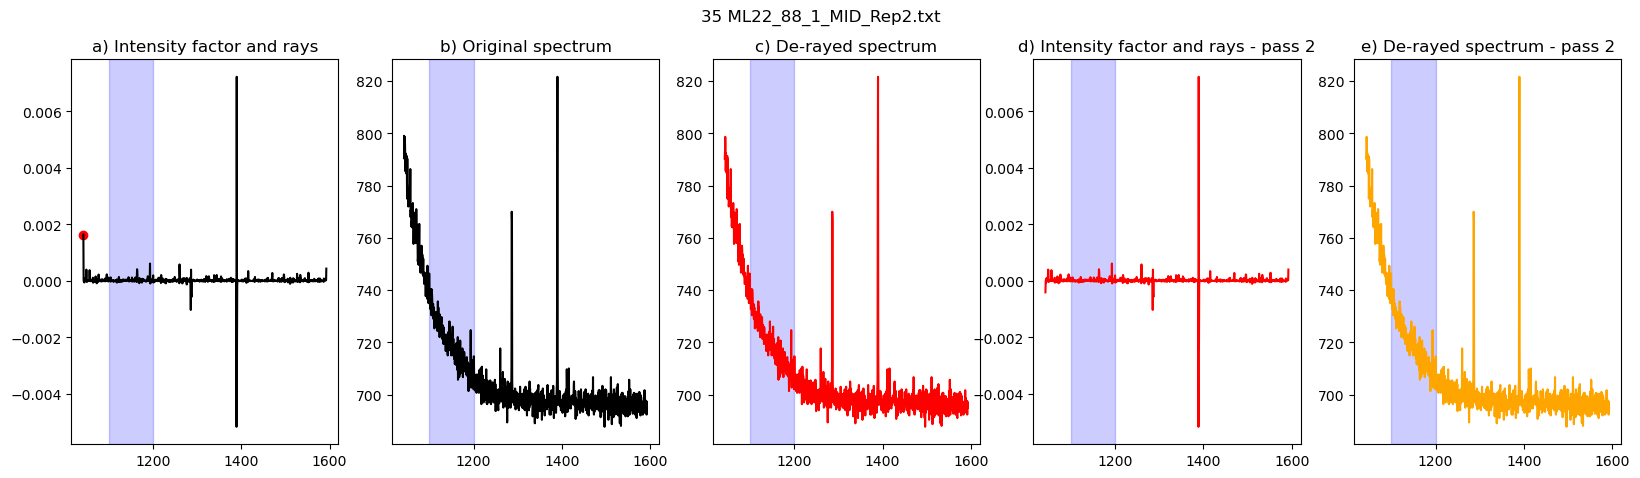

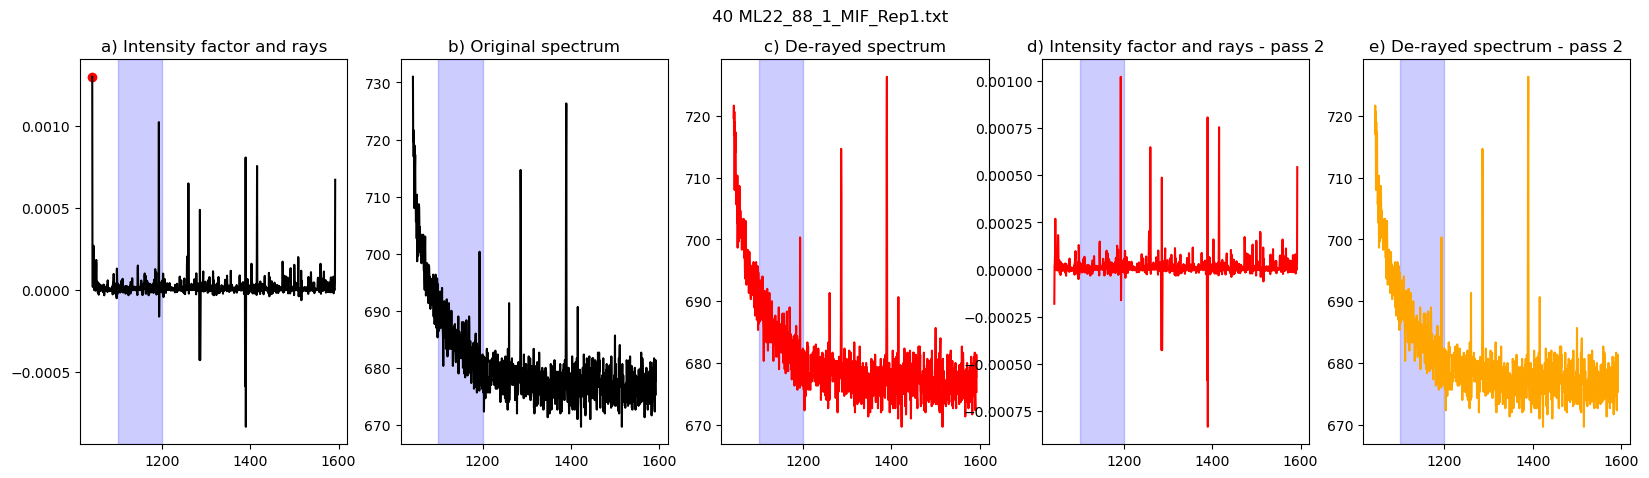

In [216]:

data_y_all_crr,fit_params_crr=pf.cosmicray_filter.filter_raysinloop(Diad_files=Diad_files, spectra_path=spectra_path, 
                exclude_ranges=exclude_ranges,
                    fit_params=fit_params, diad_peaks=diad_peaks,plot_rays=plot_rays,
                    export_cleanspec=export_cleanspec,save_fig=save_fig,dynfact=dynfact,dynfact_2=dynfact_2,n=n)

##### Plot peak parameters 
    - This will help you inspect clear cut offs you can use to split your diads into groups for fitting
    - You can enter different x and y coordinates from the dataframe headings above

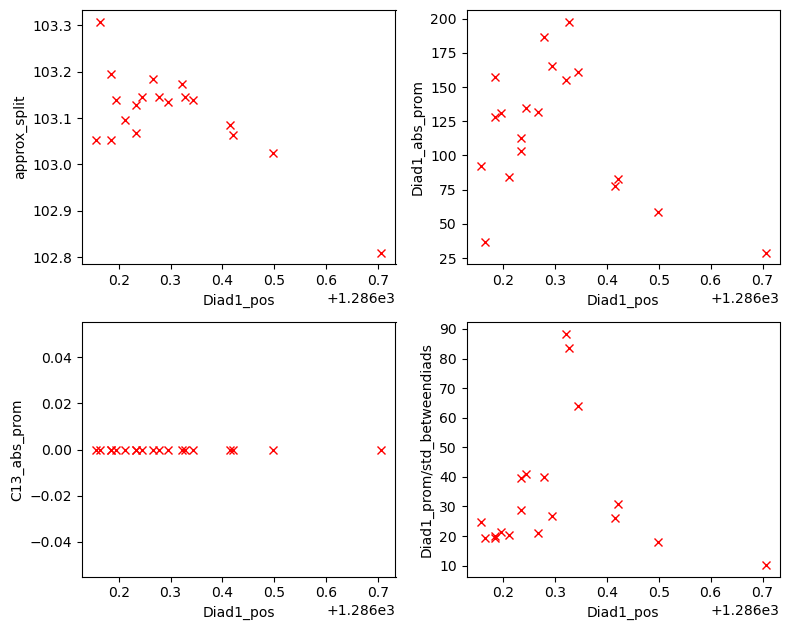

In [217]:
fig=pf.plot_peak_params(fit_params=fit_params_crr, 
                     x_param='Diad1_pos',  y1_param='approx_split',
                    y2_param='Diad1_abs_prom', y3_param='C13_abs_prom',
                    y4_param='Diad1_prom/std_betweendiads', fill_na=0)

In [218]:
fit_params_crr.head()

filename rays_present  approx_split    Diad1_pos  \
0           05 MLP_202_MIA_Rep1.txt        False    103.068312  1286.233772   
1           10 MLP_203_MIC_Rep2.txt        False    102.810311  1286.706258   
2           12 MLP_203_MIC_Rep3.txt        False    103.024315  1286.497753   
3  15 ML22_77_1_MIA_CRR_DiadFit.txt         True    103.051813  1286.184275   
4              17 ML22_77_1_MIB.txt        False    103.051813  1286.156777   

     Diad2_pos  HB1_pos  HB2_pos  C13_pos  Diad1_abs_prom  Diad2_abs_prom  \
0  1389.302084      NaN      NaN      NaN      112.923924      160.737255   
1  1389.516569      NaN      NaN      NaN       29.000000       50.299086   
2  1389.522068      NaN      NaN      NaN       58.912329       92.613844   
3  1389.236088      NaN      NaN      NaN      157.074508      245.737863   
4  1389.208590      NaN      NaN      NaN       92.175096      138.967920   

   ...  HB2_height  C13_height  Diad1_height  HB1_height  Diad1_Median_Bck  \
0  ...         NaN         NaN    813.090611         NaN        700.166687   
1  ...         NaN         NaN    730.333313         NaN        701.333313   
2  ...         NaN         NaN    778.078986         NaN        719.166657   
3  ...         NaN         NaN   1194.907821         NaN       1037.833313   
4  ...         NaN         NaN    867.008409         NaN        774.833313   

   Diad2_Median_Bck  C13_HB2_abs_prom_ratio  Diad2_HB2_Valley_prom  \
0        700.083343                     NaN                    NaN   
1        698.749985                     NaN                    NaN   
2        717.000000                     NaN                    NaN   
3       1051.250000                     NaN                    NaN   
4        775.333313                     NaN                    NaN   

   HB1_prom/std_betweendiads  HB2_prom/std_betweendiads  
0                        NaN                        NaN  
1                        NaN                        NaN  
2                        NaN                        NaN  
3                        NaN                        NaN  
4                        NaN                        NaN  

[5 rows x 40 columns]

##### Filter out ones with really bad splitting or really low diad prominence
    - Here, we only take files with splitting between 101-108 (you will need to tweak this for each instrument)
    - We also only take files with a prominence of diad 1 >10
    - You can also choose to discard based on a specific string in the file name - excxlude exclude_str='noisy'
    - None here got filtered out, but these can be helpful filters on other datasets

Keeping N=19
Discarding N=0


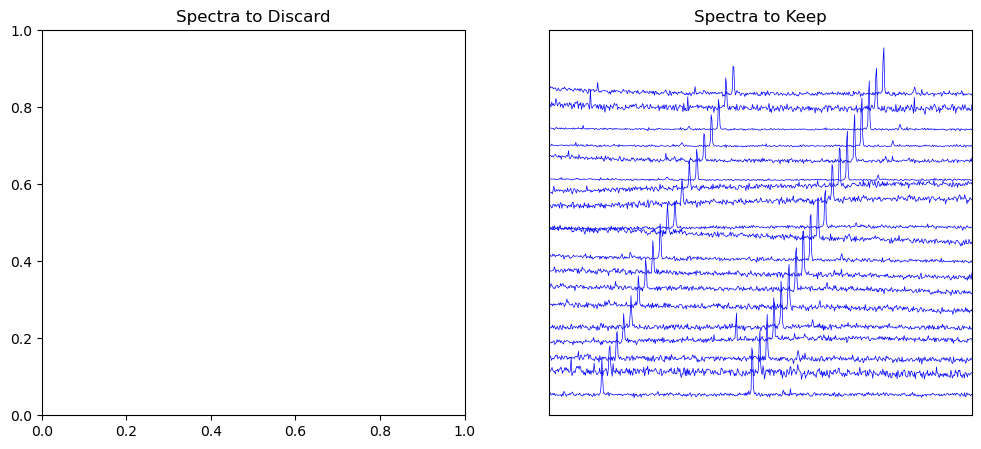

In [219]:
fit_params_filt, data_y_filt, fit_params_disc, data_y_disc=pf.filter_splitting_prominence(
fit_params=fit_params_crr, data_y_all=data_y_all, x_cord=Diad[:, 0],
splitting_limits=[101, 108], lower_diad1_prom=10, exclude_str=None)

##### Now apply filters to find the weakest diads (e.g. ones you wouldnt want to fit a hotband too)
    - In this case, we find the best filters are the position of Diad1 (shifts way more than Diad2), and where HB2 had a prominence (e.g., not nan because it wasnt found) 
    - We find it also helpful to apply a filter, e.g. weak is Diad1pos<1287 or HB2 prominence nan, and  the prominence of Diad1 is <300X the standard deviation of the diad region

(array([5., 4., 3., 3., 2., 0., 1., 0., 0., 1.]),
 array([1286.15677702, 1286.21172512, 1286.26667322, 1286.32162132,
        1286.37656941, 1286.43151751, 1286.48646561, 1286.54141371,
        1286.5963618 , 1286.6513099 , 1286.706258  ]),
 <BarContainer object of 10 artists>)

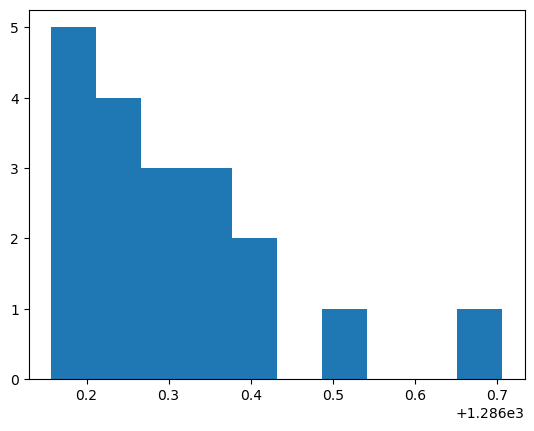

In [220]:
var='Diad1_pos'
plt.hist(fit_params_filt[var])

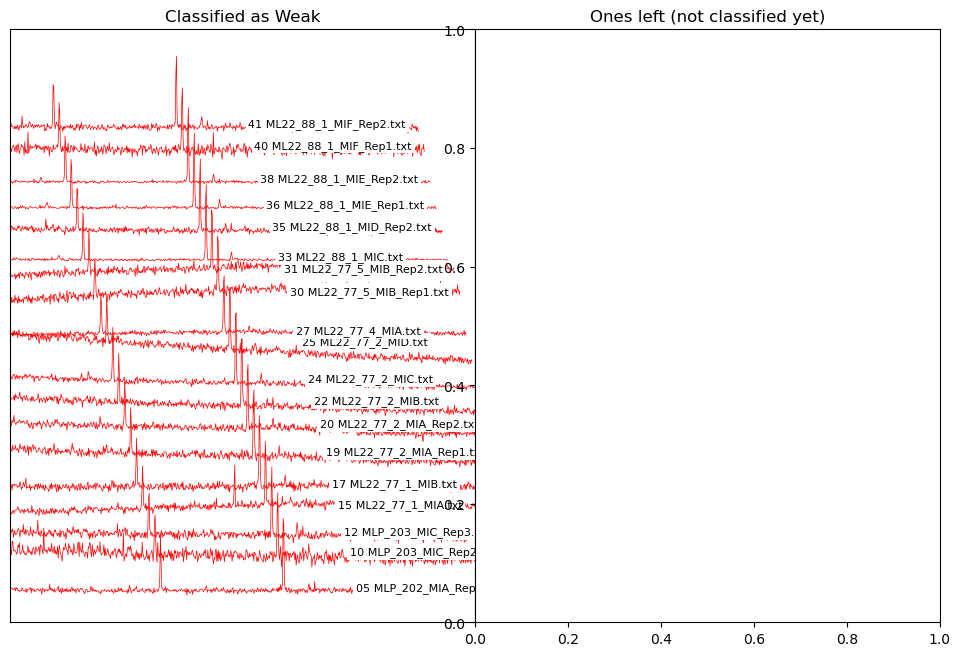

In [221]:
# Here we put spectra in the weak group if diad1 position is >1285.5 or if the av prominence of the diad relative to the standard deviation is <150

Filter2=(fit_params_filt['Av_Diad_prom/std_betweendiads']<150)
Filter3=fit_params_filt['Diad2_prom/std_betweendiads']<1100
Filter4=fit_params_filt['Diad1_pos']>1283
filter_bool=Filter4 
fit_params_Weak, fit_params_NotWeak, data_y_Weak, data_y_NotWeak=pf.identify_diad_group(
    fit_params=fit_params_filt, 
     data_y=data_y_filt, 
    x_cord=Diad[:, 0], 
    y_fig_scale=0.3,
    filter_bool=filter_bool, grp_filter='Weak')

##### Seperate Medium and strong diads
    - Now we need to find something that separates out strong diads from medium strength diads
    - The aim here is to get diads that are sufficiently strong that you have to fit a gaussian background in addition to diads, hbs and C13 peaks. Not having to fit a gaussian background to medium density diads will save you a lot of computational time (and decrease the number of bad fits)
    - In many datasets, you wont need a strong diad category. In which case, everything will stay in the 'Medium' Category
    - Here, the best filter appears to be the prominence of the C13 peak, and the general elevation of the valley between diad and HB above the background outside the diad positions (Mean_Diad_HB variable). 

In [223]:
var1='C13_abs_prom'
var2='Mean_Diad_HB_Valley_prom'
filter_bool_Strong=((fit_params_NotWeak[var1]>100)
                    &(fit_params_NotWeak[var2]>100))
# Here we make a plot of these parameters to better help select the right values
if sum(filter_bool_Strong)>0:
    fig, (ax1) = plt.subplots(1, 1, figsize=(7,4))
    ax1.plot(fit_params_NotWeak[var1].loc[filter_bool_Strong],
            fit_params_NotWeak[var2].loc[filter_bool_Strong], 'xr', label='Strong')
    ax1.plot(fit_params_NotWeak[var1].loc[~filter_bool_Strong],
            fit_params_NotWeak[var2].loc[~filter_bool_Strong], 'xk', label='Medium')

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_xlabel(var1)
    ax1.set_ylabel(var2)
    ax1.legend()
#This makes a plot
fit_params_Strong, fit_params_Medium, data_y_Strong, data_y_Medium=pf.identify_diad_group(
    fit_params=fit_params_NotWeak.reset_index(drop=True), 
    data_y=data_y_NotWeak,x_cord=Diad[:, 0], 
    filter_bool=filter_bool_Strong, y_fig_scale=0.2, grp_filter='Medium-Strong')

##### Plot weak, medium, and strong diads

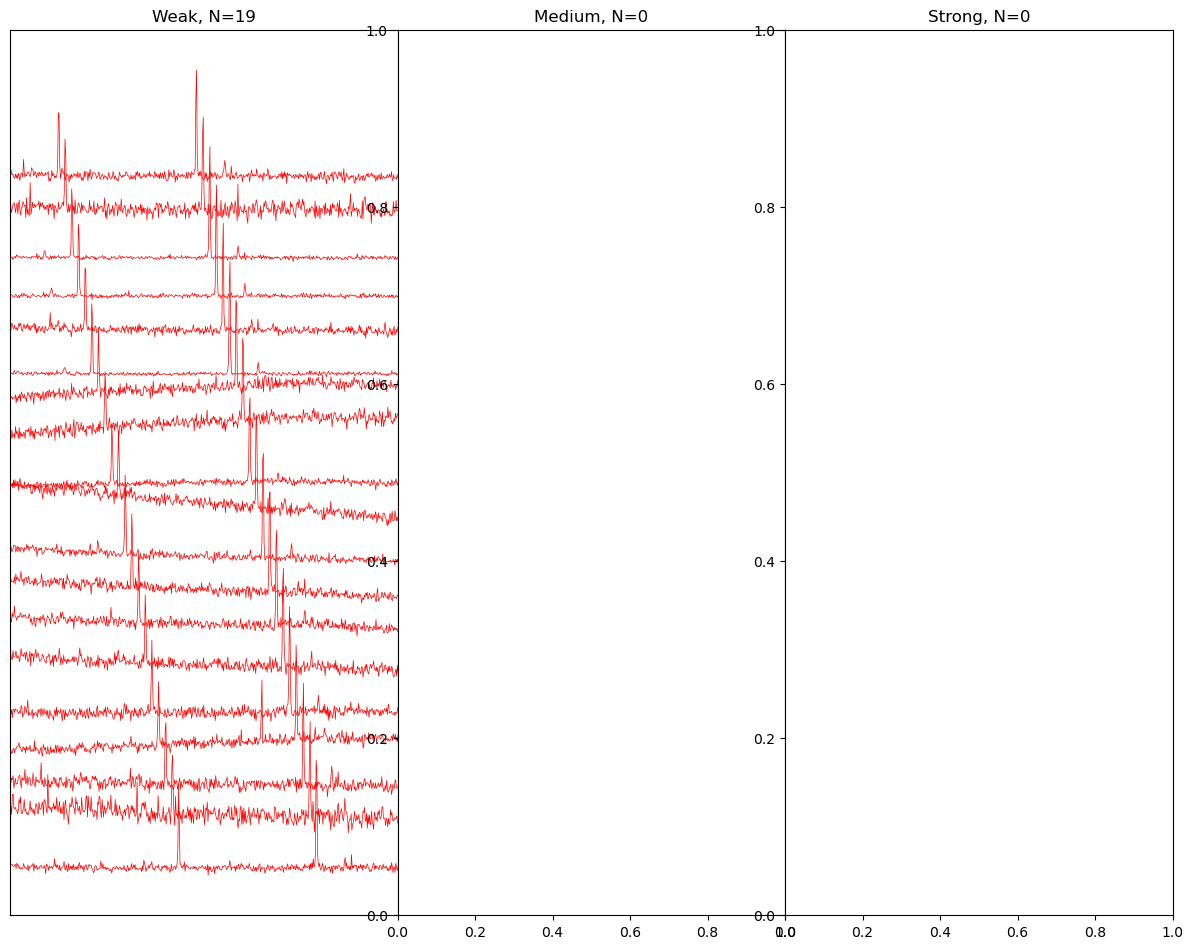

In [224]:
fig=pf.plot_diad_groups(x_cord=Diad[:, 0], Weak_np=data_y_Weak,
                 Medium_np=data_y_Medium, Strong_np=data_y_Strong,
                   y_fig_scale=0.5)

##### Now lets save these lists, and we load them in another notebook

In [225]:
import joblib
joblib.dump(Diad[:, 0], 'np_x.sav')
joblib.dump(Diad[:, 1], 'np_y.sav')
joblib.dump(fit_params_Weak.reset_index(drop=True), 'Weak_df.sav')
joblib.dump(fit_params_Medium.reset_index(drop=True), 'Medium_df.sav')
joblib.dump(fit_params_Strong.reset_index(drop=True), 'Strong_df.sav')
fit_params_disc.to_excel('Discarded_df.xlsx')